In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msn
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as st
pd.set_option('display.max_columns',None)
from sklearn.linear_model import Lasso, Ridge
import warnings
warnings.filterwarnings('ignore')

## Loading... the data

In [2]:
data=pd.read_csv('Insurance_Marketing-Customer-Value-Analysis.csv')

## Outfit of Data

In [3]:
print('Number of rows :',data.shape[0])
print('Number of columns :',data.shape[1])

Number of rows : 9134
Number of columns : 24


In [4]:
data.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/2011,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/2011,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/2011,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/2011,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/2011,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [5]:
# data['Monthly Premium Auto'].max()
# data['Months Since Last Claim'].max()
# data['Months Since Policy Inception'].max()
data['Vehicle Size'].value_counts()

Medsize    6424
Small      1764
Large       946
Name: Vehicle Size, dtype: int64

### Dropping customer column from our dataset

In [6]:
data=data.drop('Customer',axis=1)

## Handling with Datetime (Effective to Date)

### Extracting Year and Month from date

In [7]:
from datetime import datetime

data['Effective To Date'] = pd.to_datetime(data['Effective To Date'])


In [8]:
# Create date object in given time format yyyy-mm-dd
data['year'] = data['Effective To Date'].dt.year

In [9]:
data['month'] = data['Effective To Date'].dt.month
data['day']=data['Effective To Date'].dt.day

#### Extracting Day of week

In [10]:
import  calendar
data['day_of_week_number']=data['Effective To Date'].dt.weekday

In [11]:
dates_cols = ['day_of_week_number', 'month', 'day', 'year']
data[dates_cols].head()

,day_of_week_number,month,day,year
0,3,2,24,2011
1,0,1,31,2011
2,5,2,19,2011
3,3,1,20,2011
4,3,2,3,2011


In [12]:
data=data.drop('Effective To Date',axis=1)

In [13]:
j = 0
for i in calendar.day_name:
    print(j,'-',i)
    j+=1

0 - Monday
1 - Tuesday
2 - Wednesday
3 - Thursday
4 - Friday
5 - Saturday
6 - Sunday


In [14]:
num_cols=data.select_dtypes(include=['int64','float64'])
num_cols.head()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,year,month,day,day_of_week_number
0,2763.519279,56274,69,32,5,0,1,384.811147,2011,2,24,3
1,6979.535903,0,94,13,42,0,8,1131.464935,2011,1,31,0
2,12887.431650,48767,108,18,38,0,2,566.472247,2011,2,19,5
3,7645.861827,0,106,18,65,0,7,529.881344,2011,1,20,3
4,2813.692575,43836,73,12,44,0,1,138.130879,2011,2,3,3


In [15]:
num_cols=data.select_dtypes(include=['int64','float64'])
print("numerical columns")
c=1
for i in num_cols:
    print(c,'.>',i)
    c+=1

numerical columns
1 .> Customer Lifetime Value
2 .> Income
3 .> Monthly Premium Auto
4 .> Months Since Last Claim
5 .> Months Since Policy Inception
6 .> Number of Open Complaints
7 .> Number of Policies
8 .> Total Claim Amount
9 .> year
10 .> month
11 .> day
12 .> day_of_week_number


In [16]:
cat_cols=data.select_dtypes(include='object')
print("categorical columns")
c=1
for i in cat_cols:
    print(c,'.)',i)
    c+=1

categorical columns
1 .) State
2 .) Response
3 .) Coverage
4 .) Education
5 .) EmploymentStatus
6 .) Gender
7 .) Location Code
8 .) Marital Status
9 .) Policy Type
10 .) Policy
11 .) Renew Offer Type
12 .) Sales Channel
13 .) Vehicle Class
14 .) Vehicle Size


In [17]:
cat_cols.head()

,State,Response,Coverage,Education,EmploymentStatus,Gender,Location Code,Marital Status,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size
0,Washington,No,Basic,Bachelor,Employed,F,Suburban,Married,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize
1,Arizona,No,Extended,Bachelor,Unemployed,F,Suburban,Single,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize
2,Nevada,No,Premium,Bachelor,Employed,F,Suburban,Married,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize
3,California,No,Basic,Bachelor,Unemployed,M,Suburban,Married,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize
4,Washington,No,Basic,Bachelor,Employed,M,Rural,Single,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize


## FIve point Summary

In [18]:
num_cols.describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,year,month,day,day_of_week_number
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.0,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794,2011.0,1.463762,15.461134,2.988395
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092,0.0,0.498712,8.653770,2.051584
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007,2011.0,1.000000,1.000000,0.000000
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244,2011.0,1.000000,8.000000,1.000000
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434,2011.0,1.000000,15.000000,3.000000
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839,2011.0,2.000000,23.000000,5.000000
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678,2011.0,2.000000,31.000000,6.000000


In [19]:
cat_cols.describe()

,State,Response,Coverage,Education,EmploymentStatus,Gender,Location Code,Marital Status,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size
count,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134
unique,5,2,3,5,5,2,3,3,3,9,4,4,6,3
top,California,No,Basic,Bachelor,Employed,F,Suburban,Married,Personal Auto,Personal L3,Offer1,Agent,Four-Door Car,Medsize
freq,3150,7826,5568,2748,5698,4658,5779,5298,6788,3426,3752,3477,4621,6424


## Checking Missing Values

In [20]:
missing_values = data.isnull().sum() * 100/len(data)
missing_values_df = pd.DataFrame({'Column_name':data.columns,'Missing_percent':missing_values})
print(missing_values_df.to_string(index = False))

                   Column_name  Missing_percent
                         State              0.0
       Customer Lifetime Value              0.0
                      Response              0.0
                      Coverage              0.0
                     Education              0.0
              EmploymentStatus              0.0
                        Gender              0.0
                        Income              0.0
                 Location Code              0.0
                Marital Status              0.0
          Monthly Premium Auto              0.0
       Months Since Last Claim              0.0
 Months Since Policy Inception              0.0
     Number of Open Complaints              0.0
            Number of Policies              0.0
                   Policy Type              0.0
                        Policy              0.0
              Renew Offer Type              0.0
                 Sales Channel              0.0
            Total Claim Amount          

In [21]:
data = data.rename(columns = {'Customer Lifetime Value':'CLV'})

* Though we dont have any missing values in our dataset instead we will check some other factors which are making our data dirty

# Outliers or Extreme Values 

In [22]:
# from collections import Counter
# def detect_outliers(data,n,features):
#     outlier_indices = []
    
#     # iterate over features(columns)
#     for col in features:
#         # 1st quartile (25%)
#         Q1 = np.percentile(data[col], 25)
#         # 3rd quartile (75%)
#         Q3 = np.percentile(data[col],75)
#         # Interquartile range (IQR)
#         IQR = Q3 - Q1
        
#         # outlier step
#         outlier_step = 1.5 * IQR
        
#         # Determine a list of indices of outliers for feature col
#         outlier_list_col = data[(data[col] < Q1 - outlier_step) | (data[col] > Q3 + outlier_step )].index
        
#         # append the found outlier indices for col to the list of outlier indices 
#         outlier_indices.extend(outlier_list_col)
        
#     # select observations containing more than 2 outliers
#     outlier_indices = Counter(outlier_indices)        
#     multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
#     return multiple_outliers   
# outliers_to_drop=detect_outliers(data,2,num_cols)



Q1 = data['CLV'].quantile(0.25)
Q3 = data['CLV'].quantile(0.75)
IQR = Q3 - Q1
print('InterQuartileRange :',IQR)

# df2 = df1[~((df1 < (Q1 - 1.5 * IQR)) |(df1 > (Q3 + 1.5 * IQR))).any(axis=1)]
ul = Q3 + (1.5*IQR)
ll = Q1 - (1.5*IQR)
print('Upper Limit :',ul)
print('Lower Limit : ',ll)

x = data[data['CLV']>16414.03991175002].count().head(1).values
print('No. of rows that are outliers : ',x)

InterQuartileRange : 4967.915247000001
Upper Limit : 16414.039911750002
Lower Limit :  -3457.6210762500014
No. of rows that are outliers :  [817]


#### Data with outliers only

In [23]:
data[data['CLV']>16414.03991175002].head()

,State,CLV,Response,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,year,month,day,day_of_week_number
8,Oregon,24127.50402,Yes,Basic,Bachelor,Medical Leave,M,14072,Suburban,Divorced,71,13,3,0,2,Corporate Auto,Corporate L3,Offer1,Agent,511.200000,Four-Door Car,Medsize,2011,1,26,2
22,Arizona,24127.50402,Yes,Basic,Bachelor,Medical Leave,M,14072,Suburban,Divorced,71,13,3,0,2,Personal Auto,Personal L3,Offer1,Agent,511.200000,Four-Door Car,Medsize,2011,1,26,2
31,Nevada,18975.45611,No,Extended,High School or Below,Employed,M,65999,Urban,Married,237,1,14,0,6,Corporate Auto,Corporate L2,Offer2,Agent,615.927769,Luxury SUV,Medsize,2011,1,22,5
50,Oregon,36707.42639,No,Basic,College,Employed,M,24804,Suburban,Married,104,1,28,0,2,Personal Auto,Personal L2,Offer1,Agent,593.830288,SUV,Small,2011,1,17,0
51,California,33473.34946,Yes,Basic,Bachelor,Employed,F,33190,Suburban,Divorced,106,18,95,0,2,Corporate Auto,Corporate L1,Offer1,Web,508.800000,SUV,Medsize,2011,1,11,1


Since outliers can have a dramatic effect on the prediction (especially for regression problems), I chose to manage them.

I used the IQR method (Tukey JW., 1977) to detect ouliers which defines an interquartile range comprised between the 1st and 3rd quartile of the distribution values (IQR). An outlier is a row that have a feature value outside the (IQR +- an outlier step).

I decided to detect outliers from the numerical values features. Then, i considered outliers as rows that have at least two outlied numerical values

# Exploratory Data analysis

Skewness of CLV :  3.032280259929985


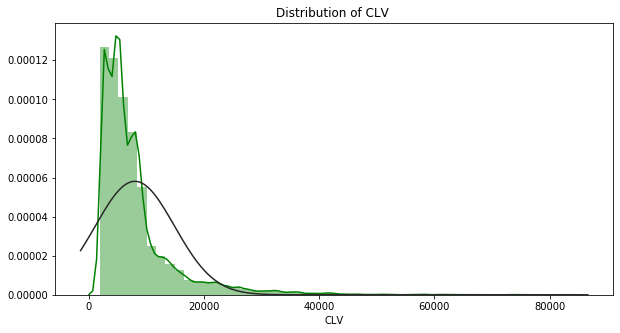

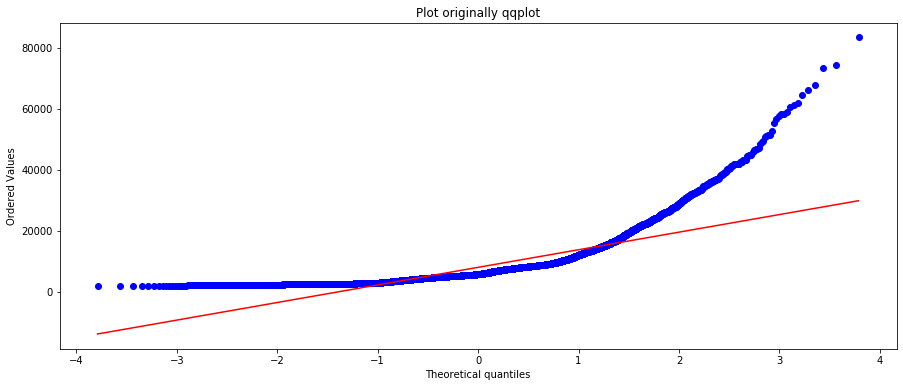

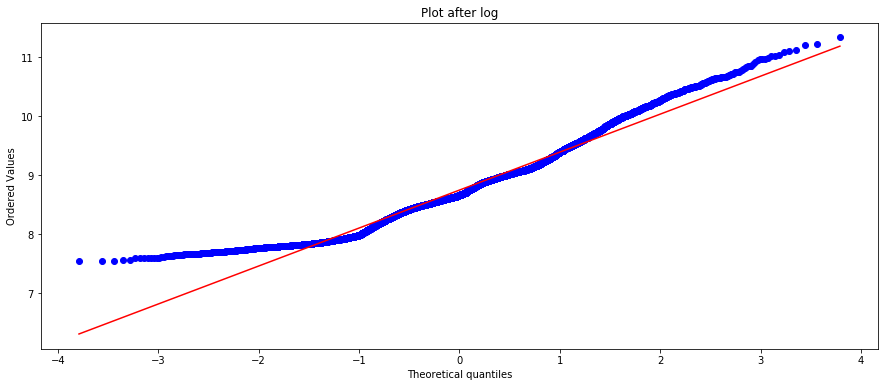

In [24]:
### distribution of CLV ( Target Variable )

print('Skewness of CLV : ',data['CLV'].skew())
plt.figure(figsize = (10,5))
sns.distplot(data['CLV'],kde = True,color = 'g',fit = stats.norm)
plt.title('Distribution of CLV ')
plt.show()

fig, ax = plt.subplots(figsize=(15,6))
rs = stats.probplot(data['CLV'],plot = ax)
plt.title('Plot originally qqplot')
plt.show()

fig, ax = plt.subplots(figsize=(15,6))
rs = stats.probplot(np.log(data['CLV']),plot = ax)
plt.title('Plot after log')
plt.show()

As we can see from the above plots . The log transformation over the target variable will help us in getting the good results.

## Univariate analysis for categorical columns with value counts and countplot

columns: State
California    3150
Oregon        2601
Arizona       1703
Nevada         882
Washington     798
Name: State, dtype: int64


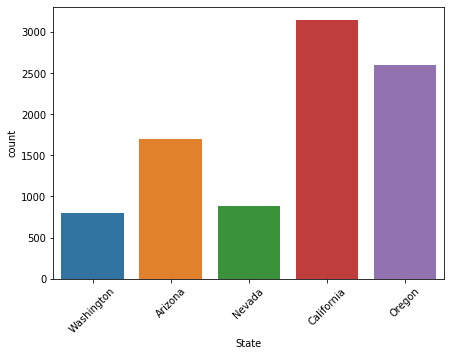



columns: Response
No     7826
Yes    1308
Name: Response, dtype: int64


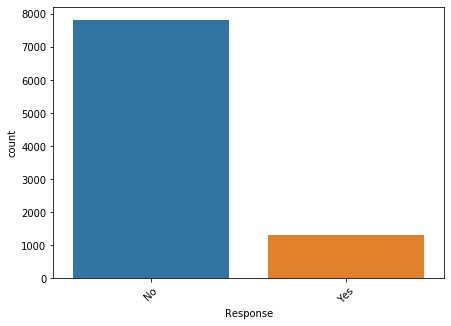



columns: Coverage
Basic       5568
Extended    2742
Premium      824
Name: Coverage, dtype: int64


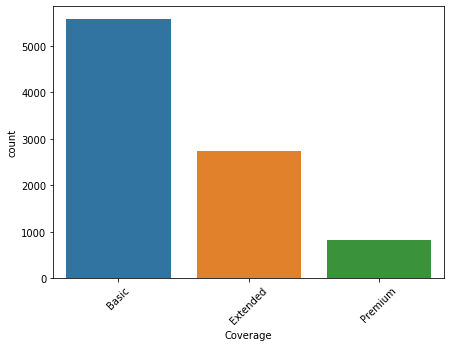



columns: Education
Bachelor                2748
College                 2681
High School or Below    2622
Master                   741
Doctor                   342
Name: Education, dtype: int64


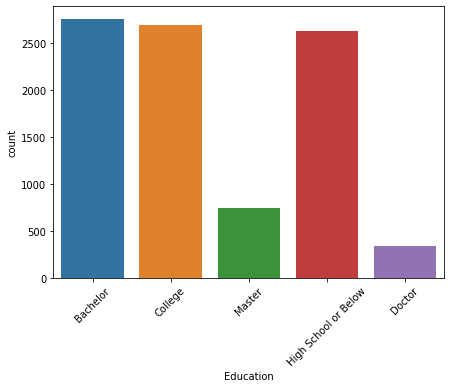



columns: EmploymentStatus
Employed         5698
Unemployed       2317
Medical Leave     432
Disabled          405
Retired           282
Name: EmploymentStatus, dtype: int64


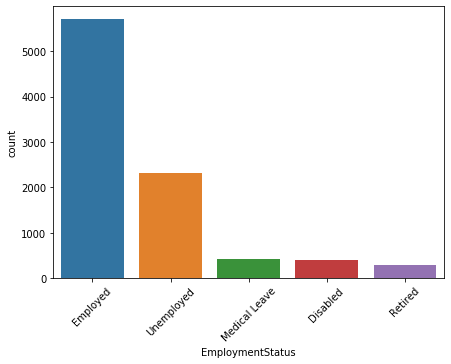



columns: Gender
F    4658
M    4476
Name: Gender, dtype: int64


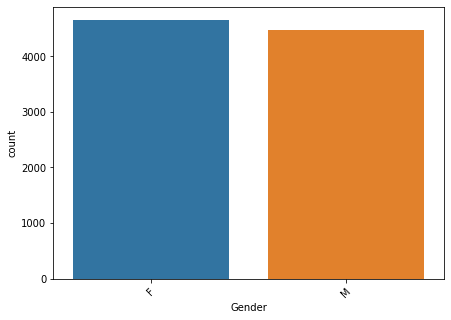



columns: Location Code
Suburban    5779
Rural       1773
Urban       1582
Name: Location Code, dtype: int64


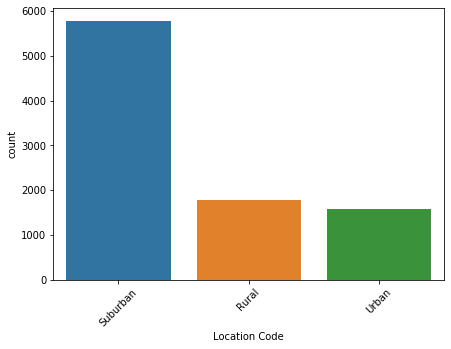



columns: Marital Status
Married     5298
Single      2467
Divorced    1369
Name: Marital Status, dtype: int64


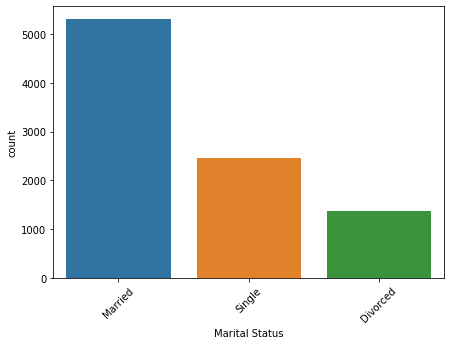



columns: Policy Type
Personal Auto     6788
Corporate Auto    1968
Special Auto       378
Name: Policy Type, dtype: int64


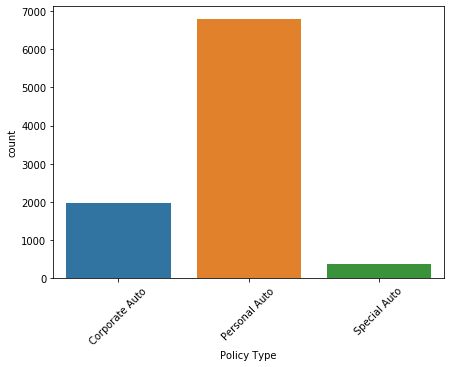



columns: Policy
Personal L3     3426
Personal L2     2122
Personal L1     1240
Corporate L3    1014
Corporate L2     595
Corporate L1     359
Special L2       164
Special L3       148
Special L1        66
Name: Policy, dtype: int64


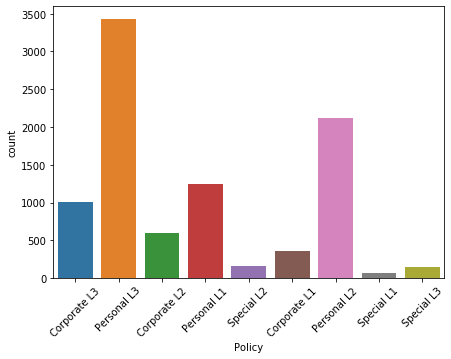



columns: Renew Offer Type
Offer1    3752
Offer2    2926
Offer3    1432
Offer4    1024
Name: Renew Offer Type, dtype: int64


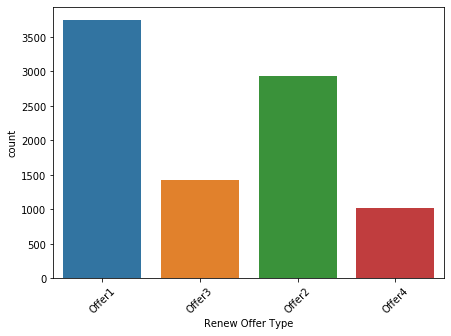



columns: Sales Channel
Agent          3477
Branch         2567
Call Center    1765
Web            1325
Name: Sales Channel, dtype: int64


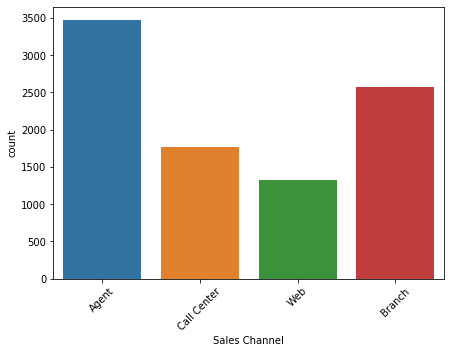



columns: Vehicle Class
Four-Door Car    4621
Two-Door Car     1886
SUV              1796
Sports Car        484
Luxury SUV        184
Luxury Car        163
Name: Vehicle Class, dtype: int64


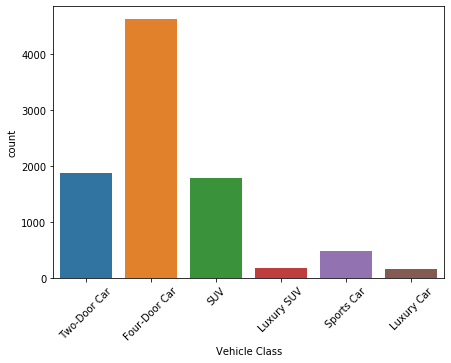



columns: Vehicle Size
Medsize    6424
Small      1764
Large       946
Name: Vehicle Size, dtype: int64


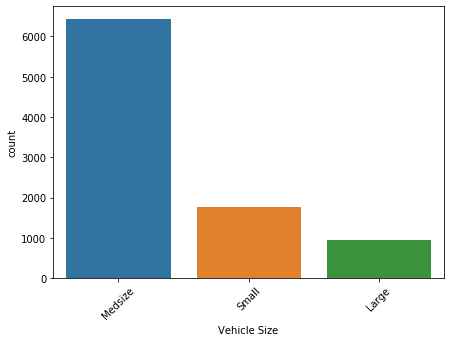

In [25]:
for i in cat_cols.columns:
    print("columns:",i)
    print(data[i].value_counts())
    f,ax=plt.subplots(figsize=(7,5))
    sns.countplot(data[i])
    plt.xticks(rotation=45)
    plt.show()
    print('\n')

*The state in maximum is california i.e 3500 approx

* The value of negative response is more compare to The  yes responsers

*There Basic coverage holders are more compare to The extended and premium customer holders

*In educational Background Bachelors are ruling over the other educational background holders

*In case of Employment the eployeed customers are more apart from the other unemployed and disabled ones.

*Female customers are more  than males.

*The Suburban residents are more other than rural and urban residentials

*The marital customers are more than singles and divorced

*Personal Auto type insurances are more prefferabke than other schemes

*Personal L3 and personal L2 are more in demand than the others.

*The Renew offer3 types seems more convinced than else offer types

*Agent sales channel made boom in getting policies

*Four door cars are more insuranced than other vehicle types

* the mid size vehicles are more in number than large and small ones

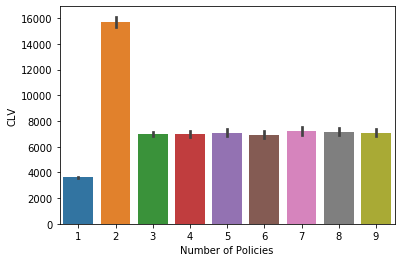

In [26]:
sns.barplot(x = 'Number of Policies',y='CLV',data = data)
plt.show()

We can see a pattern here, customers who have taken only 1 policy have lower CLV, and customers who have taken 3 or greater show a similar trend, so we can combine all of them into one bin, and we can also see that the customers who have taken 2 policies have very high CLV comparitively.

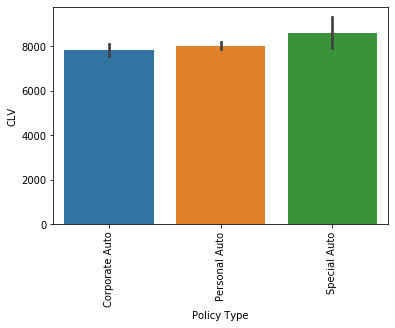

In [27]:
sns.barplot(x = 'Policy Type',y='CLV',data = data)
plt.xticks(rotation = 90)
plt.show()

There isn't much difference in the CLV w.r.t what policy type he has taken, all we need is how much revenue a customer can bring to the company, so it doesnt matter what type of policy he/she has chosen.

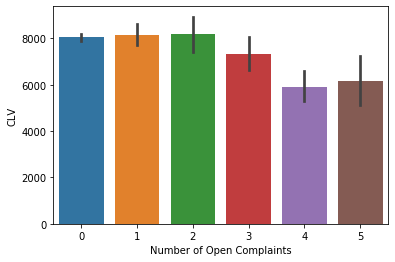

In [28]:
sns.barplot(x = 'Number of Open Complaints',y='CLV',data = data)
plt.show()

Number of open complaints also show kind of similar trend, where people who have complaints 2 or lesser have a similar pattern but where as >3 do not show any pattern we will have to do statistical test to understand if this feature is really significant or not

## Univariate analysis for numerical columns 

Column: CLV
Skewness for CLV is 3.032


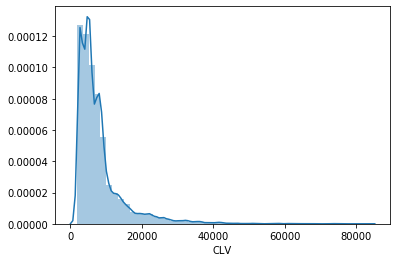

Column: Income
Skewness for Income is 0.287


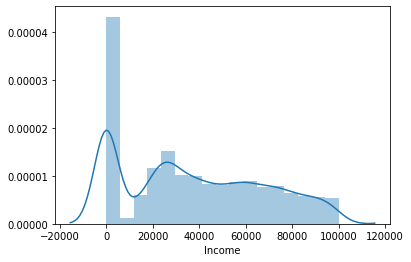

Column: Monthly Premium Auto
Skewness for Monthly Premium Auto is 2.124


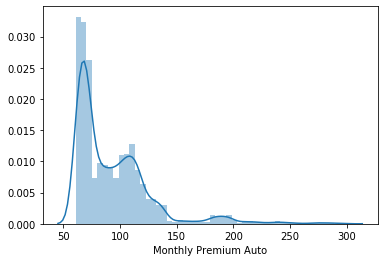

Column: Months Since Last Claim
Skewness for Months Since Last Claim is 0.279


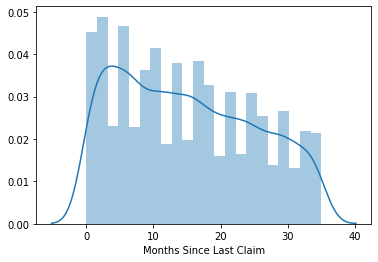

Column: Months Since Policy Inception
Skewness for Months Since Policy Inception is 0.04


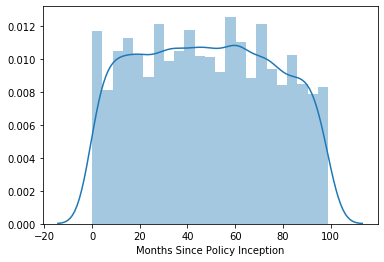

Column: Number of Open Complaints
Skewness for Number of Open Complaints is 2.783


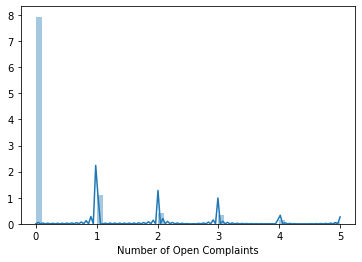

Column: Number of Policies
Skewness for Number of Policies is 1.253


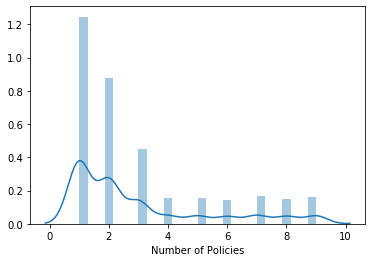

Column: Total Claim Amount
Skewness for Total Claim Amount is 1.715


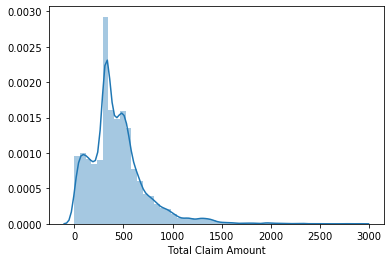

Column: year
Skewness for year is 0


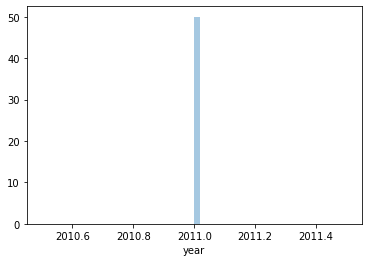

Column: month
Skewness for month is 0.145


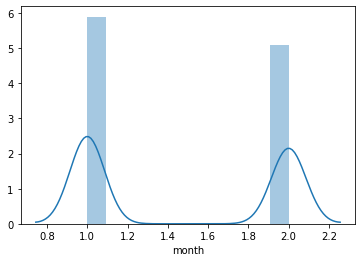

Column: day
Skewness for day is 0.007


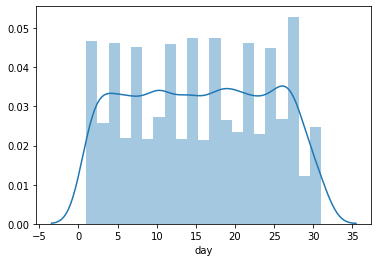

Column: day_of_week_number
Skewness for day_of_week_number is -0.027


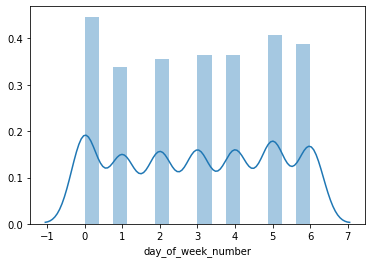

In [29]:
num_cols = data.select_dtypes(exclude = 'object')
for i in num_cols.columns:
    print ( "Column:" , i )
    print ( "Skewness for {} is {}".format ( i , round ( data [ i ].skew ( ) , 3 ) ) )
    sns.distplot ( data [ i ] )
    plt.show ( )

> CLV and Our target variable is skewed towards left

>Income column is not normally distributed and also somewhat skewed toward left

> Monthly Premium Auto is having left skewness

> Month since last claim is normally distributed

> Month since Policy inception is also normally distributed

> Number of policies is also skewed in shape

> Total claim amount is also skewed and not following normality

As we can see that there are outliers in the total claim amount and also in monthly premium auto , usually we remove the outliers for a better model.
since our dataset is related to insurance and banking industry, we must be accept the outliers,as they can be our potential customers.
And there are no outliers in the income.
Conclusion: No outlier treatment required.

As we can see that none of the continuous variables are normally distributed. So in our case , we want to make the distributions normal, we can apply some transformations to the data and see if we can achieve a normally distributed variable.


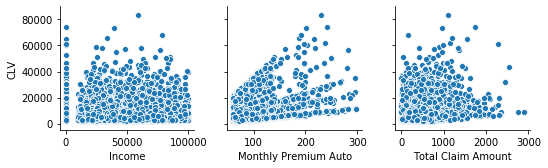

In [30]:
sns.pairplot(y_vars='CLV',x_vars=['Income','Monthly Premium Auto','Total Claim Amount'],data = data)
plt.show()

We can clearly see that there is a linear relationship between CLV and monthly premium auto, but we do not see any relationship between income and the total claim amount.

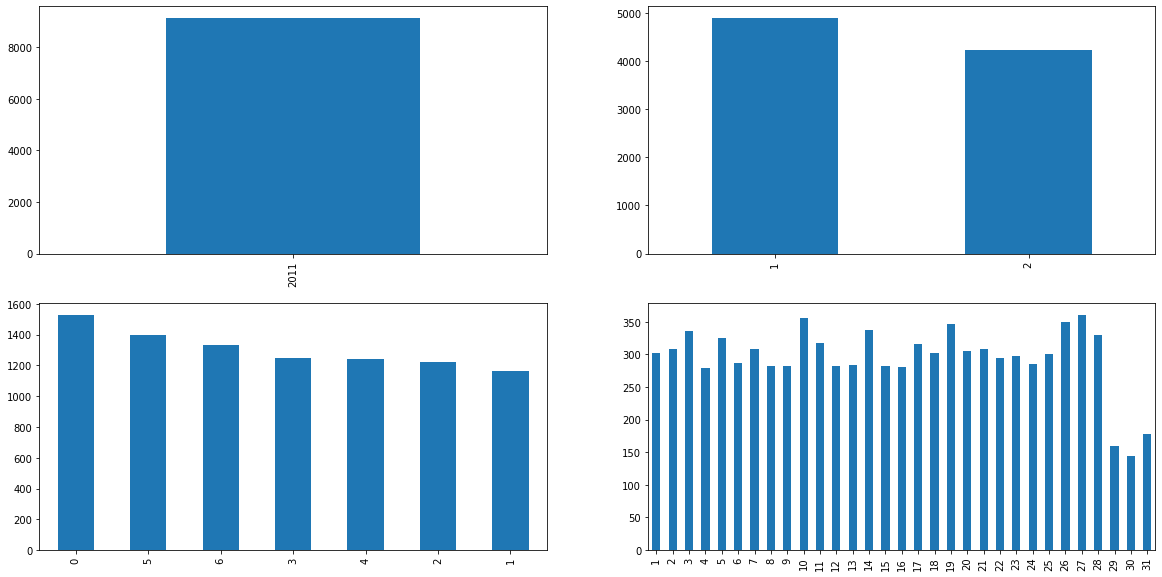

In [31]:
fig, axs = plt.subplots(2, 2)
data.year.value_counts().sort_index().plot.bar(ax=axs[0,0], figsize=(20,10))
data.month.value_counts().sort_index().plot.bar(ax=axs[0,1])
data.day_of_week_number.value_counts().plot.bar(ax=axs[1,0])
data.day.value_counts().sort_index().plot.bar(ax=axs[1,1])

since we have the data for the two months of a year 2011. the bar plots showing the frequency counts for the occurences at particular days of a week and overall frequncy count for the entire month

## Bivariate Analysis

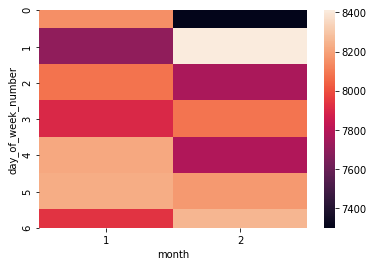

In [32]:
crosstab = pd.crosstab(index=data['day_of_week_number'], columns=data['month'], values=data['CLV'], aggfunc='mean')
sns.heatmap(crosstab)

Since we have maximum CLV for the month of  january and the weekdays include wednesday and thursday influencing
more in this month .

Apart from this february has maximum CLV for the day friday.


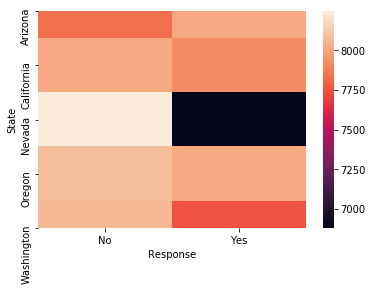

In [33]:
crosstab = pd.crosstab(index=data['State'], columns=data['Response'], values=data['CLV'], aggfunc='mean')
sns.heatmap(crosstab)

The investment in customers as positive response to generate revenue and profitabillity was more assured in the states of 
oregon,arizona with the CLV of above 8000 and the Nevada is having least customer value of 7000
other than this the negative responsers played a crucial role in gaining CLV of baove 8000 which is a
good instinct to play with.

Nevada had a negative response with the highest CLV above 8500.

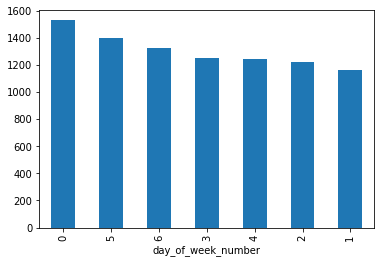

In [34]:
weekly = data.groupby(['day_of_week_number'])['Response'].count().sort_values(ascending=False)
weekly.plot.bar()

this barplot infers the response rate for the particular days of a week ,as plotted sunday is having more impactable due to response rate in customer accquisition, offline adds ,Promtions ,discounts apart from this friday is also able to be more  impactable of response

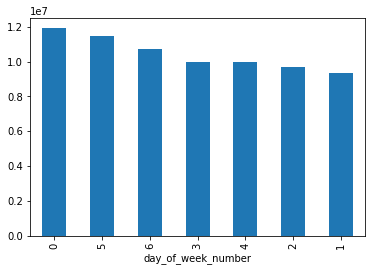

In [35]:
weekly = data.groupby(['day_of_week_number'])['CLV'].sum().sort_values(ascending=False)
weekly.plot.bar()

when it came to CLV sunday gives a better profitability than other days in a week and have a maximum 
CLV of around 1350 .

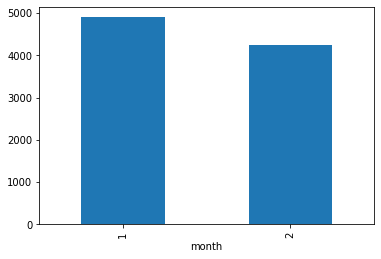

In [36]:
monthly = data.groupby(['month'])['Response'].count().sort_values(ascending=False)
monthly.plot.bar()

MAximum investments were made in the month of january for customer acquisition campaigns,offline adds and other methods  that were
around 4900

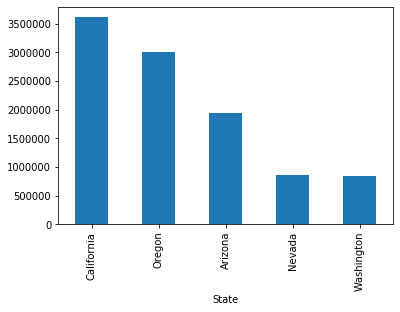

In [37]:
yes_row=data[data['Response']=='Yes']
versus_Customer_Lifetime_Value=yes_row.groupby('State')['CLV'].sum()
versus_Customer_Lifetime_Value.sort_values(ascending=False).head(10).plot.bar()

In [38]:
# califronia is having the highest sum of the CLV across the other states of the orgeon,arizona,nevada,washington

In [39]:
top2_versus=versus_Customer_Lifetime_Value.sort_values(ascending=False).head().index

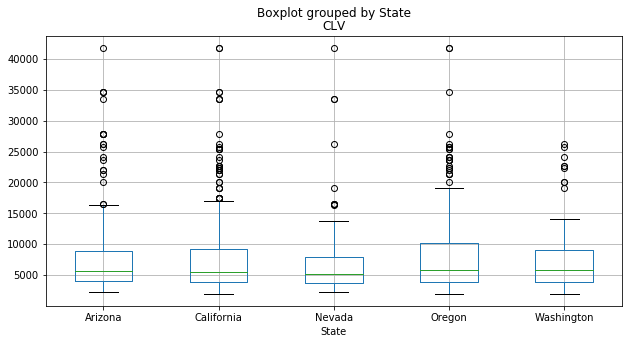

In [40]:
yes_versus=yes_row[yes_row['State'].isin(top2_versus)]

yes_versus.boxplot('CLV',by='State',figsize=(10,5))

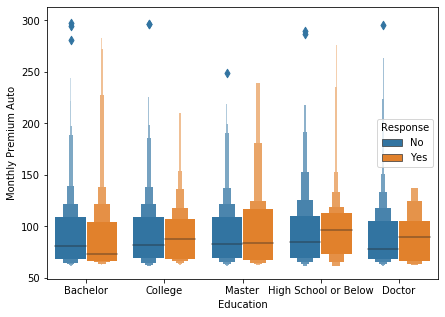

In [41]:
f , ax = plt.subplots ( figsize = ( 7 , 5 ) )
sns.boxenplot ( data [ "Education" ] , data [ "Monthly Premium Auto" ],hue=data['Response'] )
plt.show ( )

In [42]:
# Bachelors are paying more monthly premium than other classes like colleges,Master Education and Doctor categories in terms 
# of positive responsers and have a median of 60 apart from this High school and below 

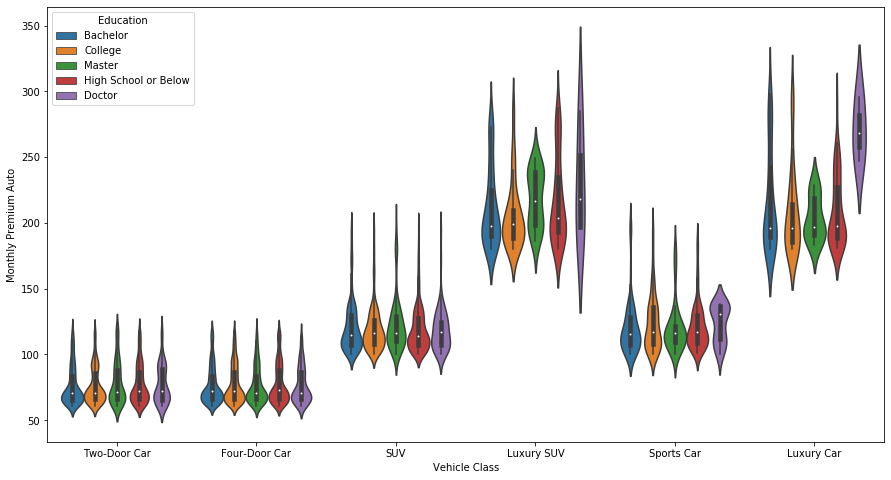

In [43]:
f , ax = plt.subplots ( figsize = ( 15, 8 ) )
sns.violinplot ( data [ "Vehicle Class" ] , data [ "Monthly Premium Auto" ],hue=data['Education'] )
plt.show ( )

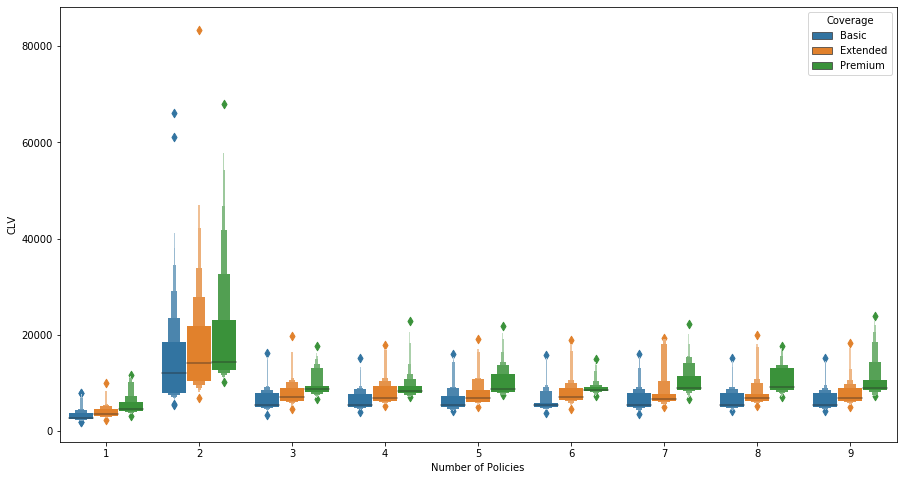

In [44]:
f , ax = plt.subplots ( figsize = ( 15, 8 ) )
sns.boxenplot ( data [ "Number of Policies" ] , data [ "CLV" ],hue=data['Coverage'] )
plt.show ( )

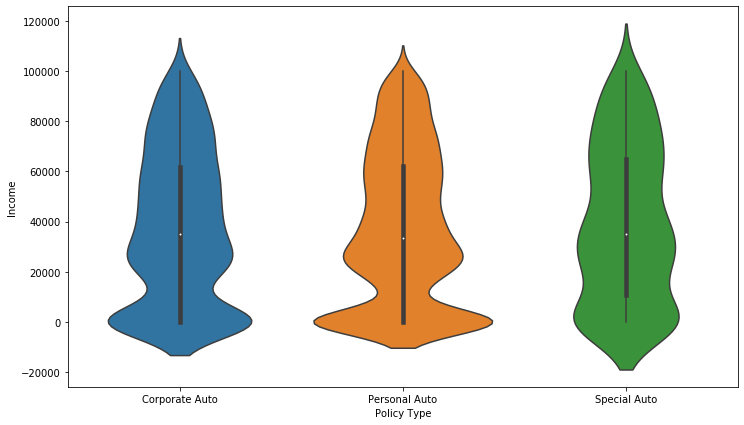

In [45]:
f , ax = plt.subplots ( figsize = ( 12 , 7 ) )
sns.violinplot ( data [ "Policy Type" ] , data [ "Income" ] )
plt.show ( )

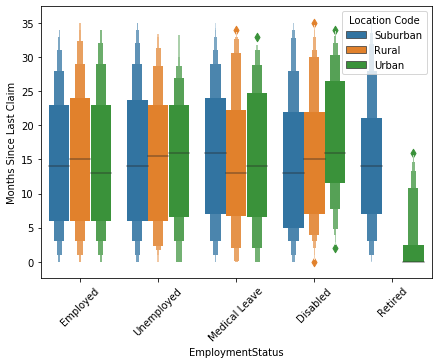

In [46]:
f , ax = plt.subplots ( figsize = ( 7 , 5 ) )
sns.boxenplot ( data [ "EmploymentStatus" ] , data [ "Months Since Last Claim" ],hue=data['Location Code'] )
plt.xticks ( rotation = 45 )
plt.show ( )

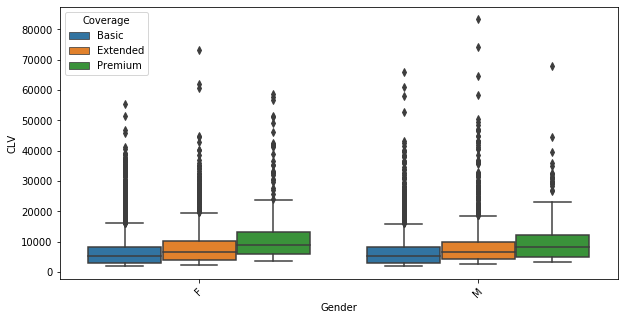

In [47]:
f , ax = plt.subplots ( figsize = ( 10 , 5 ) )
sns.boxplot(data['Gender'],data['CLV'],hue=data['Coverage'])
plt.xticks(rotation=45)
plt.show()

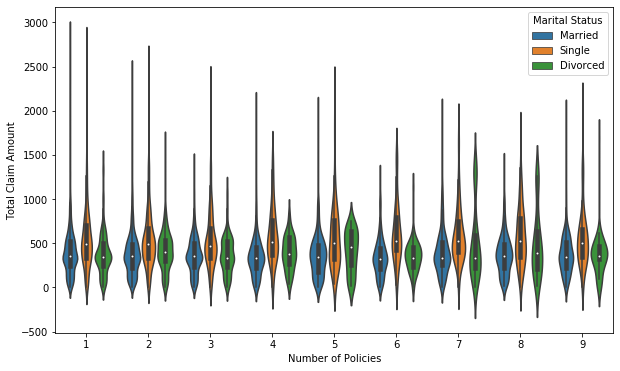

In [48]:
f , ax = plt.subplots ( figsize = ( 10 ,6 ) )
sns.violinplot ( data [ "Number of Policies" ],data['Total Claim Amount'] ,data [ "Marital Status" ] , )
plt.show ( )

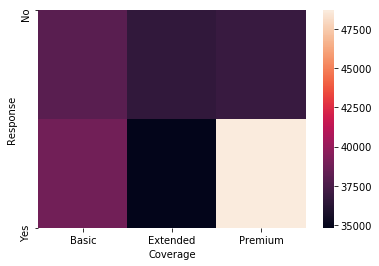

In [49]:
crosstab = pd.crosstab(index=data['Response'], columns=data['Coverage'], values=data['Income'], aggfunc='mean')
sns.heatmap(crosstab)

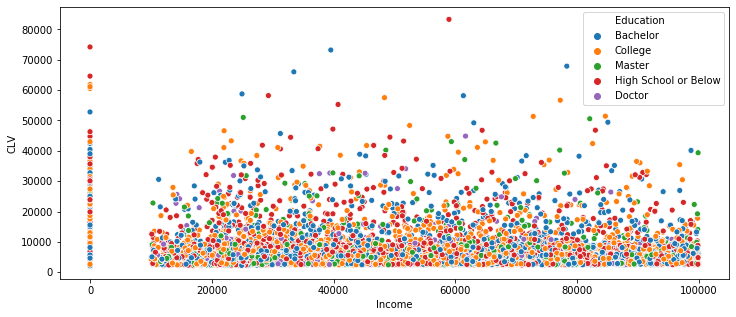

In [50]:
f , ax = plt.subplots ( figsize = ( 12 , 5 ) )
sns.scatterplot ( data [ "Income" ] , data [ "CLV" ] , hue = data [ "Education" ] )
plt.show ( )

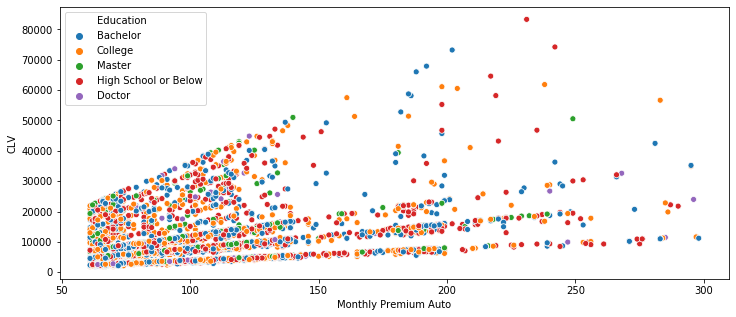

In [51]:
f , ax = plt.subplots ( figsize = ( 12 , 5 ) )
sns.scatterplot ( data [ "Monthly Premium Auto" ] , data [ "CLV" ] , hue = data [ "Education" ] )
plt.show ( )

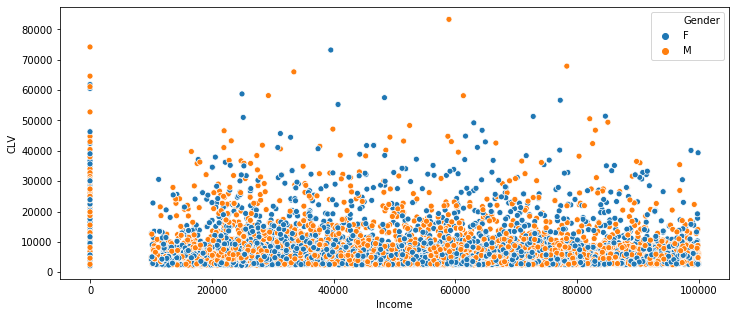

In [52]:
f , ax = plt.subplots ( figsize = ( 12 , 5 ) )
sns.scatterplot ( data [ "Income" ] , data [ "CLV" ] , hue = data [ "Gender" ] )
plt.show ( )

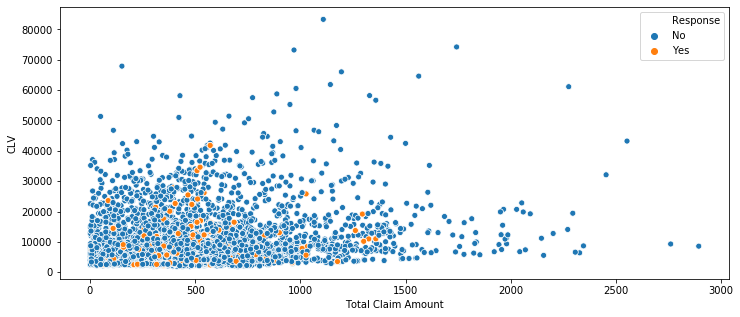

In [53]:
f , ax = plt.subplots ( figsize = ( 12 , 5 ) )
sns.scatterplot ( data [ "Total Claim Amount" ] , data [ "CLV" ] , hue = data [ "Response" ] )
plt.show ( )

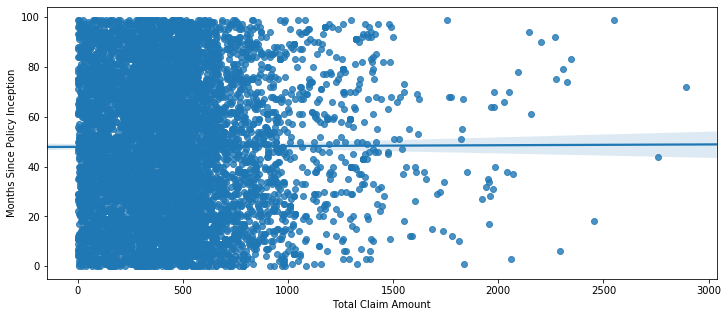

In [54]:
f , ax = plt.subplots ( figsize = ( 12 , 5 ) )
sns.regplot ( data [ "Total Claim Amount" ] , data [ "Months Since Policy Inception" ] )
plt.show ( )

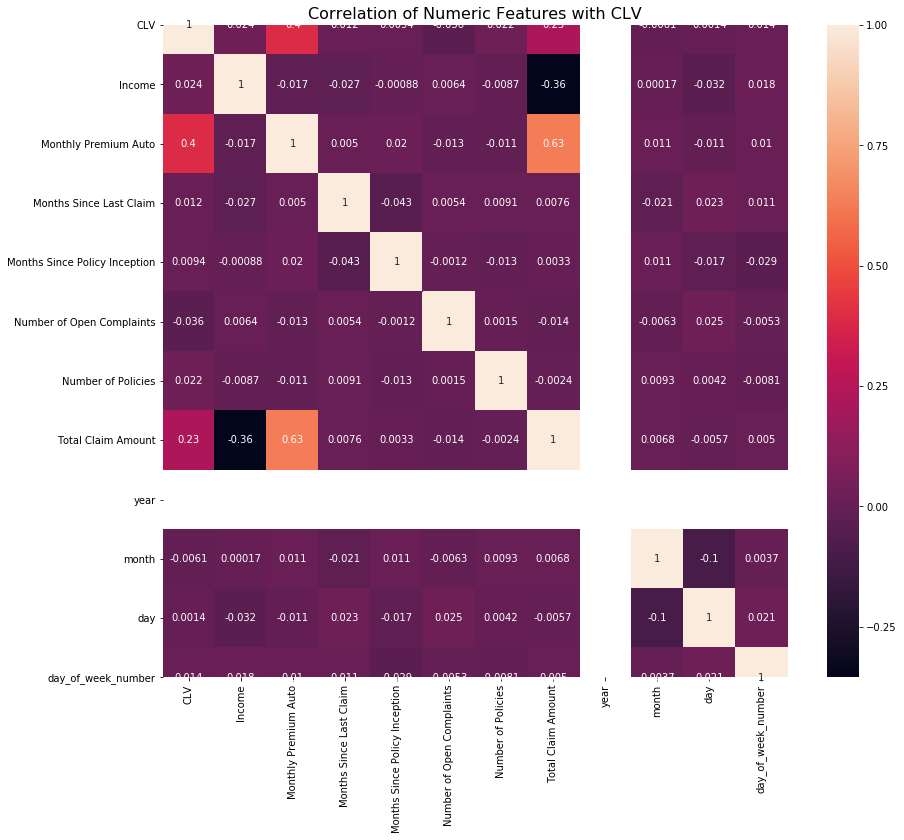

In [55]:
f , ax = plt.subplots(figsize = (14,12))

plt.title('Correlation of Numeric Features with CLV',y=1,size=16)

sns.heatmap(data.corr(),  annot=True)
plt.show()

And we can clearly see in the correlation map, that CLV has a better correlation with monthly premium auto and acceptable co relation with total claim amount, but it show's no relationship with income, so again with all the visualization's we can come to the conclusion that we can dis regard the INCOME feature.

### BASE MODEL USING OLS
Using label encoding just for the purpose of looking at the base model, encoding technique's may change furthur(one-hot encoding is used)


In [56]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cols = data.select_dtypes(object).columns
for i in cols:
    data[i] = le.fit_transform(data[i])

In [57]:
X = data.drop('CLV',axis=1)
y = data['CLV']
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [58]:
from sklearn.model_selection import train_test_split
# train data - 70% and test data - 30%
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.shape)

(6393, 25)
(2741, 25)
(2741,)
(6393,)


In [59]:
lin_reg = LinearRegression()
model = lin_reg.fit(X_train,y_train)
print(f'Coefficients: {lin_reg.coef_}')
print(f'Intercept: {lin_reg.intercept_}')
print(f'R^2 score: {lin_reg.score(X, y)}')
print(f'R^2 score for train: {lin_reg.score(X_train, y_train)}')
print(f'R^2 score for test: {lin_reg.score(X_test, y_test)}')

Coefficients: [-3.78775290e+01 -7.65699794e+02 -2.14534490e+02  1.49354573e+02
 -1.02658867e+02 -3.08488474e+01  4.08023602e-03 -3.81797990e+01
 -2.21803695e+02  7.78906510e+01  7.75536595e+00  2.65112904e+00
 -2.87751676e+02  6.16898311e+01  1.74003610e+02  4.07870955e+01
 -3.85888334e+02  9.53855698e+01 -2.86324301e-02  5.45781175e+01
  1.10768046e+02  1.13686838e-13 -1.18623082e+02 -2.40581477e-01
  3.57290514e+01]
Intercept: 587.0950434556007
R^2 score: 0.16376572985747517
R^2 score for train: 0.1683899628471991
R^2 score for test: 0.15430743438896188


In [60]:
import statsmodels.api as sm
X_sm = X
X_sm = sm.add_constant(X_sm)
lm = sm.OLS(y,X_sm).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CLV   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     75.19
Date:                Wed, 05 Feb 2020   Prob (F-statistic):               0.00
Time:                        23:12:03   Log-Likelihood:                -92834.
No. Observations:                9134   AIC:                         1.857e+05
Df Residuals:                    9109   BIC:                         1.859e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
State                            27.8762     51.126      0.545      0.586     -72.342     128.095
Response                       -459.2518    192.806     -2.382      0.017    -837.195     -81.308
Coverage                       -184.3730    113.720     -1.621      0.105    -407.289      38.543
Education                        92.5407     47.794      1.936      0.053      -1.146     186.228
EmploymentStatus               -106.9485     73.613     -1.453      0.146    -251.246      37.349
Gender                         -145.5858    132.648     -1.098      0.272    -405.606     114.435
Income                            0.0022      0.003      0.667      0.505      -0.004       0.009
Location Code                   100.6493    116.603      0.863      0.388    -127.918     329.216
Marital Status                 -240.2018    110.694     -2.170      0.030    -457.186     -23.218
Monthly Premium Auto             82.6863      2.925     28.271      0.000      76.953      88.419
Months Since Last Claim           6.4821      6.550      0.990      0.322      -6.357      19.321
Months Since Policy Inception    -0.6709      2.375     -0.283      0.778      -5.326       3.984
Number of Open Complaints      -249.2682     72.387     -3.444      0.001    -391.162    -107.374
Number of Policies               63.7311     27.666      2.304      0.021       9.499     117.964
Policy Type                     447.6573    291.072      1.538      0.124    -122.909    1018.224
Policy                          -47.6764     86.267     -0.553      0.581    -216.779     121.426
Renew Offer Type               -347.6404     68.522     -5.073      0.000    -481.959    -213.322
Sales Channel                    22.3858     62.304      0.359      0.719     -99.744     144.516
Total Claim Amount               -0.5766      0.362     -1.593      0.111      -1.286       0.133
Vehicle Class                    45.5802     32.427      1.406      0.160     -17.985     109.145
Vehicle Size                    188.7697    123.409      1.530      0.126     -53.139     430.679
year                              0.3090      0.269      1.147      0.252      -0.219       0.837
month                          -160.7967    132.756     -1.211      0.226    -421.027      99.434
day                               4.6860      7.663      0.612      0.541     -10.334      19.706
day_of_week_number               26.5332     32.128      0.826      0.409     -36.445      89.511
==============================================================================
Omnibus:                     5663.042   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            64517.119
Skew:                           2.850   Prob(JB):                         0.00
Kurtosis:              

After Looking at the base model and the p-value of the feature's, we know that the Hypothesis for the feature's is

H0: Feature is not significant Ha: Feature is significant But we just cant conclude the significance of the feature's just by base model and also without using any of the feature engineering technique's we have at our disposal. So we will first try to do the statistical test's of the feature for the feature selection, we can also use the forward selection and backward elimination , we will use the Variance inflation factor

### Linear Regression Assumptions

#### Check for linearity- Rainbow Test
The Null hypothesis is that the regression is correctly modelled as linear. The alternative for which the power might be large are convex

In [61]:
sm.stats.diagnostic.linear_rainbow(lm, frac=0.5)

(1.0160754105715937, 0.2952672468607285)

We accept null  Hypothesis

Linearity test is passed

### Test for Multicollinearity¶

In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif=[variance_inflation_factor(X.values,i)for i in range (X.shape[1])]
pd.DataFrame({'vif':vif},index=X.columns)

,vif
State,1.002053
Response,1.054500
Coverage,1.285787
Education,1.008514
EmploymentStatus,2.275529
Gender,1.016600
Income,2.263962
Location Code,1.153212
Marital Status,1.148773
Monthly Premium Auto,2.341140


### 3 . no heteroscedaticity( residuals are homoscedatic)

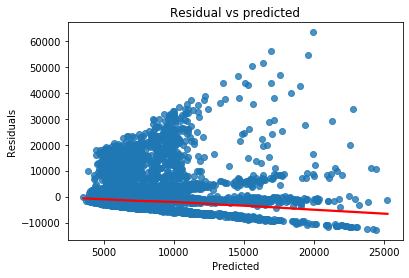

In [63]:
y_pred=lm.predict()
resids=lm.resid

fig,ax=plt.subplots()
sns.regplot(y_pred,resids,lowess=True,line_kws={'color':'red'})
ax.set_title('Residual vs predicted')                   
ax.set(xlabel='Predicted',ylabel='Residuals')
plt.show()

In [64]:
import statsmodels.stats.api as sms


name=['F-statistic','p-value']
test=sms.het_goldfeldquandt(lm.resid,lm.model.exog)
test

(1.2278437884383377, 2.4192812410459493e-12, 'increasing')

goldfledquandt tsest for homoscedasticity .since probability is much more  than alpha we fail to reject null hypothesis and  that residual are homoscedatic

### 4.Auto-corelation

In [65]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(lm.resid)

1.9960264285531293

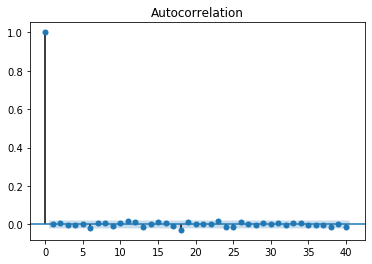

In [66]:
import statsmodels.tsa.api as smt
acf=smt.graphics.plot_acf(lm.resid,lags=40)
acf.show()

# Statistical Modelling

### Test of relationship using Chi-square test to check the associations between categorical variables

In [67]:
data=pd.read_csv('Insurance_Marketing-Customer-Value-Analysis.csv')
data = data.rename(columns = {'Customer Lifetime Value': 'CLV'})

In [68]:
data.head()

,Customer,State,CLV,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/2011,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/2011,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/2011,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/2011,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/2011,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [69]:
cat1 , cat2 = [ ] , [ ]
for i in cat_cols.columns:
    if data [ i ].nunique ( ) == 2:
        cat1.append ( i )
    else:
        cat2.append ( i )

### Statistical tests with target variable

In [70]:
data['State'].value_counts()

California    3150
Oregon        2601
Arizona       1703
Nevada         882
Washington     798
Name: State, dtype: int64

In [71]:
cl=data[data['State']=='California']['CLV']
org=data[data['State']=='Oregon']['CLV']
ar=data[data['State']=='Arizona']['CLV']
Nv=data[data['State']=='Nevada']['CLV']
Wa=data[data['State']=='Washington']['CLV']

In [72]:
a=stats.kruskal(cl,org,ar,Nv,Wa)
a

KruskalResult(statistic=5.072069583836472, pvalue=0.27998232358818953)

- As we pvalue is greater than aplha therfore accept H0 &
- the state will not impact to predict CLVs

In [73]:
catg=data.select_dtypes(include=['object'])
catg.drop(['Customer','Effective To Date'],1,inplace=True)

In [74]:
col=list(catg.columns)
print(len(col))
col
ttest=[]
anova=[]
for i in col:
    if len(data[i].unique())<3:
        ttest.append(i)
    else:
        anova.append(i)

print(ttest)
print(anova)

14
['Response', 'Gender']
['State', 'Coverage', 'Education', 'EmploymentStatus', 'Location Code', 'Marital Status', 'Policy Type', 'Policy', 'Renew Offer Type', 'Sales Channel', 'Vehicle Class', 'Vehicle Size']


In [75]:
data1=data.iloc[1:1670,:]
data1.shape
print(stats.shapiro(data1['CLV']))
# print(stats.jarque_bera(data['Months Since Last Claim']))

(0.7297053337097168, 1.401298464324817e-45)


- As pvalue is less tha alpha, which we can consider 5% so therefore we reject H0 and we conculed that our traget verible is     not normally distributed

- so therefore we go with non-parametric test

In [76]:
num=data.select_dtypes(exclude=['object'])
num.columns

Index(['CLV', 'Income', 'Monthly Premium Auto', 'Months Since Last Claim',
       'Months Since Policy Inception', 'Number of Open Complaints',
       'Number of Policies', 'Total Claim Amount'],
      dtype='object')

In [77]:
yes=data[data['Response']=='No']['CLV']
no=data[data['Response']=='Yes']['CLV']



In [78]:
b=stats.mannwhitneyu(yes,no)
b[1]

0.2584436122645599

In [79]:
female=data[data['Gender']=='F']['CLV']
male=data[data['Gender']=='M']['CLV']

In [80]:
f=stats.mannwhitneyu(female,male)
f

MannwhitneyuResult(statistic=10337134.0, pvalue=0.24374651528224917)

- we test above two features with non-Paramteric unpaired ttest and  we concluded that those 2 faetures is not significant 
  to predict traget 

### One Way Anova

In [81]:
print('columns for anova : ')
anova

columns for anova : 


['State',
 'Coverage',
 'Education',
 'EmploymentStatus',
 'Location Code',
 'Marital Status',
 'Policy Type',
 'Policy',
 'Renew Offer Type',
 'Sales Channel',
 'Vehicle Class',
 'Vehicle Size']

#### State

In [82]:
ca=data[data['State']=='California']['CLV']
Or=data[data['State']=='Oregon']['CLV']
Ar=data[data['State']=='Arizona']['CLV']
Ne=data[data['State']=='Nevada']['CLV']
Wa=data[data['State']=='Washington']['CLV']

In [83]:
stats.kruskal(ca,Or,Ar,Ne,Wa)


KruskalResult(statistic=5.072069583836472, pvalue=0.27998232358818953)

#### Coverage

In [84]:
data['Coverage'].value_counts()

Basic       5568
Extended    2742
Premium      824
Name: Coverage, dtype: int64

In [85]:
Ba=data[data['Coverage']=='Basic']['CLV']
Ex=data[data['Coverage']=='Extended']['CLV']
Pr=data[data['Coverage']=='Premium']['CLV']

In [86]:
c=stats.kruskal(Ba,Ex,Pr)
c

KruskalResult(statistic=502.4996090762843, pvalue=7.648852917746348e-110)

#### Education

In [87]:
data['Education'].value_counts()

Bachelor                2748
College                 2681
High School or Below    2622
Master                   741
Doctor                   342
Name: Education, dtype: int64

In [88]:
Ba=data[data['Education']=='Bachelor']['CLV']
Co=data[data['Education']=='College']['CLV']
Hi=data[data['Education']=='High School or Below']['CLV']
Ma=data[data['Education']=='Master']['CLV']
Da=data[data['Education']=='Doctor']['CLV']

In [89]:
d=stats.kruskal(Ba,Co,Hi,Ma,Da)
d

KruskalResult(statistic=12.234061758188824, pvalue=0.015693004298603028)

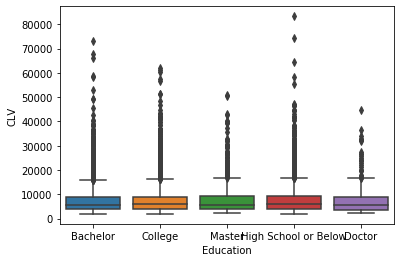

In [90]:
sns.boxplot(y='CLV',x='Education',data=data)
plt.show()

#### Employement Status

In [91]:

data['EmploymentStatus'].value_counts()

Employed         5698
Unemployed       2317
Medical Leave     432
Disabled          405
Retired           282
Name: EmploymentStatus, dtype: int64

In [92]:
Ba=data[data['EmploymentStatus']=='Employed']['CLV']
Co=data[data['EmploymentStatus']=='Unemployed']['CLV']
Hi=data[data['EmploymentStatus']=='Medical Leave']['CLV']
Ma=data[data['EmploymentStatus']=='Disabled']['CLV']
Da=data[data['EmploymentStatus']=='Retired']['CLV']

In [93]:
e=stats.kruskal(Ba,Co,Hi,Ma,Da)
e

KruskalResult(statistic=42.56159302970864, pvalue=1.2758458797542519e-08)

#### Location Code

In [94]:
data['Location Code'].value_counts()

Suburban    5779
Rural       1773
Urban       1582
Name: Location Code, dtype: int64

In [95]:
Ba=data[data['Location Code']=='Suburban']['CLV']
Co=data[data['Location Code']=='Rural']['CLV']
Hi=data[data['Location Code']=='Urban']['CLV']

In [96]:
g=stats.kruskal(Ba,Co,Hi)
g

KruskalResult(statistic=2.4638212999332567, pvalue=0.29173464205664124)

#### Marital Status

In [97]:
data['Marital Status'].value_counts()

Married     5298
Single      2467
Divorced    1369
Name: Marital Status, dtype: int64

In [98]:
Ba=data[data['Marital Status']=='Married']['CLV']
Co=data[data['Marital Status']=='Single']['CLV']
Hi=data[data['Marital Status']=='Divorced']['CLV']

In [99]:
h=stats.kruskal(Ba,Co,Hi)
h

KruskalResult(statistic=20.895798766808223, pvalue=2.9009146434700455e-05)

#### Policy Type

In [100]:
data['Policy Type'].value_counts()

Personal Auto     6788
Corporate Auto    1968
Special Auto       378
Name: Policy Type, dtype: int64

In [101]:
Ba=data[data['Policy Type']=='Personal Auto']['CLV']
Co=data[data['Policy Type']=='Corporate Auto']['CLV']
Hi=data[data['Policy Type']=='Special Auto']['CLV']

In [102]:
i=stats.kruskal(Ba,Co,Hi)
i

KruskalResult(statistic=4.6074986354931795, pvalue=0.0998836452694168)

#### Policy

In [103]:
data['Policy'].value_counts()

Personal L3     3426
Personal L2     2122
Personal L1     1240
Corporate L3    1014
Corporate L2     595
Corporate L1     359
Special L2       164
Special L3       148
Special L1        66
Name: Policy, dtype: int64

In [104]:
Ba=data[data['Policy']=='Personal L3']['CLV']
Co=data[data['Policy']=='Personal L2']['CLV']
Hi=data[data['Policy']=='Personal L1']['CLV']
Ma=data[data['Policy']=='Corporate L3']['CLV']
Da=data[data['Policy']=='Corporate L2']['CLV']
Ca=data[data['Policy']=='Corporate L1']['CLV']
s1=data[data['Policy']=='Special L2']['CLV']
s2=data[data['Policy']=='Special L3']['CLV']
s3=data[data['Policy']=='Special L1']['CLV']

In [105]:
j=stats.kruskal(Ba,Co,Hi,Ma,Da,Ca,s1,s2,s3)
j

KruskalResult(statistic=7.944351884462466, pvalue=0.4389248352544014)

#### Renew Offer Type

In [106]:
data['Renew Offer Type'].value_counts()

Offer1    3752
Offer2    2926
Offer3    1432
Offer4    1024
Name: Renew Offer Type, dtype: int64

In [107]:
Ba=data[data['Renew Offer Type']=='Offer1']['CLV']
Co=data[data['Renew Offer Type']=='Offer2']['CLV']
Hi=data[data['Renew Offer Type']=='Offer3']['CLV']
Ma=data[data['Renew Offer Type']=='Offer4']['CLV']

In [108]:
k=stats.kruskal(Ba,Co,Hi,Ma)
k

KruskalResult(statistic=168.90219457792458, pvalue=2.196144881912684e-36)

#### Sales Channel

In [109]:
data['Sales Channel'].value_counts()

Agent          3477
Branch         2567
Call Center    1765
Web            1325
Name: Sales Channel, dtype: int64

In [110]:
Ba=data[data['Sales Channel']=='Agent']['CLV']
Co=data[data['Sales Channel']=='Branch']['CLV']
Hi=data[data['Sales Channel']=='Call Center']['CLV']
Ma=data[data['Sales Channel']=='Web']['CLV']

In [111]:
l=stats.kruskal(Ba,Co,Hi,Ma)
l

KruskalResult(statistic=4.491751501229693, pvalue=0.2130272157209903)

#### Vehicle Class

In [112]:
data['Vehicle Class'].value_counts()

Four-Door Car    4621
Two-Door Car     1886
SUV              1796
Sports Car        484
Luxury SUV        184
Luxury Car        163
Name: Vehicle Class, dtype: int64

In [113]:
Ba=data[data['Vehicle Class']=='Four-Door Car']['CLV']
Co=data[data['Vehicle Class']=='Two-Door Car']['CLV']
Hi=data[data['Vehicle Class']=='SUV']['CLV']
Ma=data[data['Vehicle Class']=='Sports Car']['CLV']
Da=data[data['Vehicle Class']=='Luxury SUV']['CLV']
Ca=data[data['Vehicle Class']=='Luxury Car']['CLV']

In [114]:
m=stats.kruskal(Ba,Co,Hi,Ma,Da,Ca)
m

KruskalResult(statistic=1310.5494960284416, pvalue=3.309676344717952e-281)

#### Vehicle Size

In [115]:
data['Vehicle Size'].value_counts()

Medsize    6424
Small      1764
Large       946
Name: Vehicle Size, dtype: int64

In [116]:
Ba=data[data['Vehicle Size']=='Medsize']['CLV']
Co=data[data['Vehicle Size']=='Small']['CLV']
Hi=data[data['Vehicle Size']=='Large']['CLV']

In [117]:
n=stats.kruskal(Ba,Co,Hi)
n[1]

0.00837505335446059

In [118]:
z=[a[1],b[1],c[1],d[1],e[1],f[1],g[1],h[1],i[1],j[1],k[1],l[1],m[1],n[1]]
len(z)
z

[0.27998232358818953,
 0.2584436122645599,
 7.648852917746348e-110,
 0.015693004298603028,
 1.2758458797542519e-08,
 0.24374651528224917,
 0.29173464205664124,
 2.9009146434700455e-05,
 0.0998836452694168,
 0.4389248352544014,
 2.196144881912684e-36,
 0.2130272157209903,
 3.309676344717952e-281,
 0.00837505335446059]

In [119]:
data2=pd.DataFrame({'Column':col,'P_values':z})
pval = []
for i in data2.P_values:
    i = round(i,3)
    pval.append(i)
data2['P_values'] = pval    
data2

,Column,P_values
0,State,0.280
1,Response,0.258
2,Coverage,0.000
3,Education,0.016
4,EmploymentStatus,0.000
5,Gender,0.244
6,Location Code,0.292
7,Marital Status,0.000
8,Policy Type,0.100
9,Policy,0.439


In [120]:
data2['status']=data2['P_values'].map(lambda x:'Significant' if x<0.05 else 'Not_Significant')
data2

,Column,P_values,status
0,State,0.280,Not_Significant
1,Response,0.258,Not_Significant
2,Coverage,0.000,Significant
3,Education,0.016,Significant
4,EmploymentStatus,0.000,Significant
5,Gender,0.244,Not_Significant
6,Location Code,0.292,Not_Significant
7,Marital Status,0.000,Significant
8,Policy Type,0.100,Not_Significant
9,Policy,0.439,Not_Significant


#### Stats model for continous variables only

In [121]:
num=data.select_dtypes(exclude=['object'])
num.head()

,CLV,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
0,2763.519279,56274,69,32,5,0,1,384.811147
1,6979.535903,0,94,13,42,0,8,1131.464935
2,12887.431650,48767,108,18,38,0,2,566.472247
3,7645.861827,0,106,18,65,0,7,529.881344
4,2813.692575,43836,73,12,44,0,1,138.130879


In [122]:
X=num.drop('CLV',axis=1)
y=num['CLV']
# xc=sm.add_constant(x)
lin_reg=sm.OLS(y,X).fit()
lin_reg.summary()                                                                     



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    CLV   R-squared (uncentered):                   0.644
Model:                            OLS   Adj. R-squared (uncentered):              0.643
Method:                 Least Squares   F-statistic:                              2356.
Date:                Wed, 05 Feb 2020   Prob (F-statistic):                        0.00
Time:                        23:12:37   Log-Likelihood:                         -92862.
No. Observations:                9134   AIC:                                  1.857e+05
Df Residuals:                    9127   BIC:                                  1.858e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Income                            0.0054      0.002      2.345      0.019       0.001       0.010
Monthly Premium Auto             83.2032      2.336     35.614      0.000      78.624      87.783
Months Since Last Claim           8.1813      6.059      1.350      0.177      -3.697      20.059
Months Since Policy Inception     0.9475      2.144      0.442      0.659      -3.255       5.150
Number of Open Complaints      -234.3584     71.998     -3.255      0.001    -375.490     -93.227
Number of Policies               80.8845     26.222      3.085      0.002      29.484     132.285
Total Claim Amount               -0.6451      0.326     -1.980      0.048      -1.284      -0.007
==============================================================================
Omnibus:                     5672.518   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            64904.825
Skew:                           2.855   Prob(JB):                         0.00
Kurtosis:                      14.744   Cond. No.                     5.29e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Chi Square test for categorical vs Categorical features

In [123]:
for i in cat2:
    for j in cat1:
        print ( "Chi-square test for {} and {}".format ( i , j ) )
        print ( "Hypothesis testing for association between {} and {}".format ( i , j ) )
        print ( "Ha : There is an association between {} and {}".format ( i , j ) )
        print ( "Ha : There is no association between {} and {}".format ( i , j ) )
        pvalue = round ( stats.chi2_contingency ( pd.crosstab ( data [ i ] , data [ j ] ) ) [ 1 ] , 5 )
        print ( "p-value is" , pvalue ) 
        if pvalue < 0.05:
            print ( "We reject Ho since p-value of {} is less than alpha of 0.05.".format ( pvalue ) )
            print ( "Hence, we conclude by accepting alternate hypothesis." )
            print ( "Ha : There is an association between {} and {}".format ( i , j ) )
        else:
            print ( "We fail to reject Ho since p-value of {} is greater than alpha of 0.05.".format ( pvalue ) )
            print ( "Hence, we conclude by accepting null hypothesis." )
            print ( "Ho : There is no association between {} and {}".format ( i , j ) )
        print ( "\n" )

Chi-square test for State and Response
Hypothesis testing for association between State and Response
Ha : There is an association between State and Response
Ha : There is no association between State and Response
p-value is 0.97921
We fail to reject Ho since p-value of 0.97921 is greater than alpha of 0.05.
Hence, we conclude by accepting null hypothesis.
Ho : There is no association between State and Response


Chi-square test for State and Gender
Hypothesis testing for association between State and Gender
Ha : There is an association between State and Gender
Ha : There is no association between State and Gender
p-value is 0.87888
We fail to reject Ho since p-value of 0.87888 is greater than alpha of 0.05.
Hence, we conclude by accepting null hypothesis.
Ho : There is no association between State and Gender


Chi-square test for Coverage and Response
Hypothesis testing for association between Coverage and Response
Ha : There is an association between Coverage and Response
Ha : There i

In [124]:
data['CLV']=data['CLV']

In [125]:
# data['CLV']= np.log(data['CLV'])
# data['CLV'].skew()
# plt.hist(data['CLV'],color='green')
data.head()

,Customer,State,CLV,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/2011,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/2011,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/2011,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/2011,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/2011,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


# Categorical vs continuous

## CLV Vs Gender

Stating the Hypothesis:

    H0: Mu_male=Mu_female
    
    H1: Mu_male!=Mu_Female

In [126]:
#1st check the assumptions
male=data[data['Gender']=='M']
female=data[data['Gender']=='F']

In [127]:
#The sample is drawn highly Random
male.CLV.mean()

7909.551487979678

In [128]:
female.mean()

CLV                               8096.602370
Income                           38108.176471
Monthly Premium Auto                93.087162
Months Since Last Claim             14.844998
Months Since Policy Inception       47.949764
Number of Open Complaints            0.387076
Number of Policies                   2.928081
Total Claim Amount                 412.856483
dtype: float64

the differnce in mean shows the sample is drawn highly random

### Let's check the normality of CLV

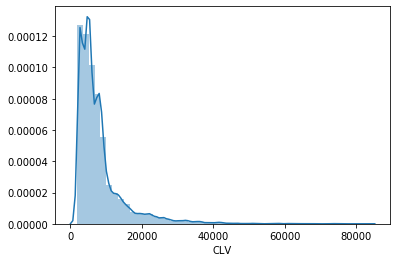

In [129]:
sns.distplot(data['CLV'])

In [130]:
data.head()

,Customer,State,CLV,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/2011,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/2011,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/2011,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/2011,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/2011,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [131]:
data['CLV'].skew()

3.032280259929985

#### Statistical check for normality

In [132]:
st.shapiro(data['CLV'])

(0.7033728361129761, 0.0)

though our p value is less than alpha so we can assume our target variable is not noe=rmally dstributed and we can go for non-paraetric
test that is mean-whiteneyu

In [133]:
st.mannwhitneyu(male.CLV,female.CLV)

MannwhitneyuResult(statistic=10337134.0, pvalue=0.24374651528224917)

this inferred 0.24 > pvalue(0.05) makes our null hypothesis to be true and says Mu_male=Mu_female

#### Check for variance

though our data is not following normality and is nonparamteric so we will go with bartlett for checking the variance in data

In [134]:
st.bartlett(male.CLV,female.CLV)

BartlettResult(statistic=2.9723646724055572, pvalue=0.08469796550462214)

though the pvalue got is greeter than alpha and we will conclude that the our data is foollowing the variance and null hypothesis is true

### when all the test of assumption is accepted go for t test

In [135]:
st.ttest_ind(male.CLV,female.CLV)

Ttest_indResult(statistic=-1.300686352501256, pvalue=0.19339865630769232)

conclusion: both male and female CLV is as same as our pvalue is grrater than alpha (0.05)

## Response vs CLV

In [136]:
yes=data[data['Response']=='Yes']
no=data[data['Response']=='No']

In [137]:
## we have already checked the above all the assuumptions and it doesnot follow normality so directly apply mannwhitney test
st.mannwhitneyu(yes.CLV,no.CLV)

MannwhitneyuResult(statistic=5060988.0, pvalue=0.2584436122645599)

In [138]:
# p value>alpha(0.05) so accept ho means their is no difference in the avg CLV rate of yes resposers and no responders 

In [139]:
st.bartlett(yes.CLV,no.CLV)#h0 accepted

BartlettResult(statistic=24.772236577725185, pvalue=6.452013724908971e-07)

so variance is same for both the condition  as p value is greter thean alpha 0.05

In [140]:
st.ttest_ind(yes.CLV,no.CLV)

Ttest_indResult(statistic=-0.8533582829612565, pvalue=0.393483030479461)

inferred that the CLV is same for the yes and no responsers

# vs region¶


In [141]:
# H0: mu_r1=mu_r2=mu_r3=mu_r4
# H1: mu_r1!=mu_r2!=mu_r3!=mu_r4

In [142]:
# assumptions: 1.randomness 2.normality 3.variance equality
# 1. assumed randomness 
# 2. normality i already chekced,assume for a while it follows its normal
#3. variance equality(need to check)

In [143]:
data['Location Code'].unique()

array(['Suburban', 'Rural', 'Urban'], dtype=object)

In [144]:
cls=data[data['Location Code']=='Suburban']['CLV'] ##income of inner city
clr=data[data['Location Code']=='Rural']['CLV']
clu=data[data['Location Code']=='Urban']['CLV']

In [145]:
st.levene(cls,clr,clu) ##accpts ho means variance is same for all leveles

LeveneResult(statistic=0.31576692259922945, pvalue=0.7292373599726338)

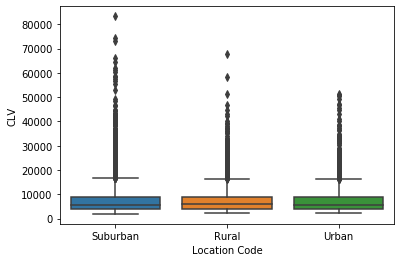

In [146]:
sns.boxplot(y='CLV',x='Location Code',data=data)

In [147]:
st.f_oneway(clr,cls,clu)

F_onewayResult(statistic=0.10800210605345337, pvalue=0.8976268526407198)

In [148]:
# since income is not satisfied the normality,we should do kruskalwali test
st.kruskal(clr,cls,clu)

KruskalResult(statistic=2.4638212999332567, pvalue=0.29173464205664124)

### is there assosciation Between Vehicle size and Response

In [149]:
# H1: there is  assosciation between vehicle size and Response
# h0:there is  no association between vehicle size and Response
# alpha=0.5

cpl=pd.crosstab(data['Vehicle Size'],data['Response'])
cpl

Response,No,Yes
Vehicle Size,,
Large,778,168
Medsize,5482,942
Small,1566,198


In [150]:
stats.chi2_contingency(cpl)

(23.513731678546584,
 7.835343516518603e-06,
 2,
 array([[ 810.53164003,  135.46835997],
        [5504.07532297,  919.92467703],
        [1511.393037  ,  252.606963  ]]))

In [151]:
stats.chi2.ppf(0.95,2)

5.991464547107979

pvalue(7.835343516518603e-06)is very very small nearer to zero and less than alpha so reject null hypothesis and accept H1 means have assosciation between the vehicle size and response

### Modelling

In [152]:
data.head()

,Customer,State,CLV,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/2011,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/2011,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/2011,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/2011,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/2011,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [153]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


In [154]:
## only with continuous variables
Algorithms = []
R2_score = []
RMSE = []
y = num['CLV']
X = num.iloc[:,1:]
trainX, testX, trainY, testY = train_test_split(X, y, train_size = 0.7, random_state = 42)
def model(algo):
    name = str(algo).split('(')[0] + ' numerical features only'
    predY = algo.fit(trainX,trainY).predict(testX)
    print('-----',name,'-----')
    r2 = round(r2_score(testY,predY),3)
    rmse = round(np.sqrt(mean_squared_error(testY,predY)),2)
    print('r2_score : ',r2_score(testY,predY))
    print('RMSE : ',np.sqrt(mean_squared_error(testY,predY)))
    print('\n')
    
    Algorithms.append(name)
    R2_score.append(r2)
    RMSE.append(rmse)

lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()

models = [lr, dt, rf]
for i in models:
    model(i)
    
print(Algorithms)
print(R2_score)
print(RMSE)
pd.DataFrame({'Models':Algorithms,'R2_score':R2_score,'RMSE':RMSE})

----- LinearRegression numerical features only -----
r2_score :  0.15595821765379125
RMSE :  6627.469720048556


----- DecisionTreeRegressor numerical features only -----
r2_score :  0.4658138813650845
RMSE :  5272.445246466117


----- RandomForestRegressor numerical features only -----
r2_score :  0.6670974607073887
RMSE :  4162.213304958328


['LinearRegression numerical features only', 'DecisionTreeRegressor numerical features only', 'RandomForestRegressor numerical features only']
[0.156, 0.466, 0.667]
[6627.47, 5272.45, 4162.21]


,Models,R2_score,RMSE
0,LinearRegression numerical features only,0.156,6627.47
1,DecisionTreeRegressor numerical features only,0.466,5272.45
2,RandomForestRegressor numerical features only,0.667,4162.21


In [155]:

lin_reg = sm.OLS(y,X).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    CLV   R-squared (uncentered):                   0.644
Model:                            OLS   Adj. R-squared (uncentered):              0.643
Method:                 Least Squares   F-statistic:                              2356.
Date:                Wed, 05 Feb 2020   Prob (F-statistic):                        0.00
Time:                        23:12:45   Log-Likelihood:                         -92862.
No. Observations:                9134   AIC:                                  1.857e+05
Df Residuals:                    9127   BIC:                                  1.858e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Income                            0.0054      0.002      2.345      0.019       0.001       0.010
Monthly Premium Auto             83.2032      2.336     35.614      0.000      78.624      87.783
Months Since Last Claim           8.1813      6.059      1.350      0.177      -3.697      20.059
Months Since Policy Inception     0.9475      2.144      0.442      0.659      -3.255       5.150
Number of Open Complaints      -234.3584     71.998     -3.255      0.001    -375.490     -93.227
Number of Policies               80.8845     26.222      3.085      0.002      29.484     132.285
Total Claim Amount               -0.6451      0.326     -1.980      0.048      -1.284      -0.007
==============================================================================
Omnibus:                     5672.518   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            64904.825
Skew:                           2.855   Prob(JB):                         0.00
Kurtosis:                      14.744   Cond. No.                     5.29e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [156]:
## All features
X = data.drop(['CLV','Customer','Effective To Date'],1)
y = data['CLV']
cat_col = catg.columns
X = pd.get_dummies(X, columns=cat_col,drop_first = True)
trainX, testX, trainY, testY = train_test_split(X, y, train_size = 0.7, random_state = 42)
def model(algo):
    name = str(algo).split('(')[0] + ' base model'
    predY = algo.fit(trainX,trainY).predict(testX)
    print('-----',name,'-----')
    print('r2_score : ',r2_score(testY,predY))
    print('RMSE : ',np.sqrt(mean_squared_error(testY,predY)))
    print('\n')
    r2 = round(r2_score(testY,predY),3)
    rmse = round(np.sqrt(mean_squared_error(testY,predY)),2)
    Algorithms.append(name)
    R2_score.append(r2)
    RMSE.append(rmse)

lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()

models = [lr, dt, rf]
for i in models:
    model(i)
pd.DataFrame({'Models':Algorithms,'R2_score':R2_score,'RMSE':RMSE})    

----- LinearRegression base model -----
r2_score :  0.15409698591281396
RMSE :  6634.772951063405


----- DecisionTreeRegressor base model -----
r2_score :  0.46686598162124937
RMSE :  5267.25054482456


----- RandomForestRegressor base model -----
r2_score :  0.6913454022838628
RMSE :  4007.7641351957955




,Models,R2_score,RMSE
0,LinearRegression numerical features only,0.156,6627.47
1,DecisionTreeRegressor numerical features only,0.466,5272.45
2,RandomForestRegressor numerical features only,0.667,4162.21
3,LinearRegression base model,0.154,6634.77
4,DecisionTreeRegressor base model,0.467,5267.25
5,RandomForestRegressor base model,0.691,4007.76


In [157]:
## All features

X = data.drop(['CLV','Customer'],1)
X['Effective To Date']  = pd.to_datetime(X['Effective To Date'])
X['month'] = X['Effective To Date'].dt.month
X = X.drop('Effective To Date',1)
X['month'] = X['month'].astype('object')

y = data['CLV']
cat_col = ['State','Response','Coverage','Education','EmploymentStatus','Gender','Location Code','Marital Status',
           'Number of Open Complaints','Number of Policies','Policy Type','Policy','Renew Offer Type','Sales Channel',
           'Vehicle Class','Vehicle Size','month']
X = pd.get_dummies(X, columns=cat_col,drop_first = True)
Xc  = sm.add_constant(X)
lin_reg=sm.OLS(y,Xc).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CLV   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     265.7
Date:                Wed, 05 Feb 2020   Prob (F-statistic):               0.00
Time:                        23:12:47   Log-Likelihood:                -89027.
No. Observations:                9134   AIC:                         1.782e+05
Df Residuals:                    9073   BIC:                         1.786e+05
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                          -4105.4040    601.758     -6.822      0.000   -5284.985   -2925.823
Income                            -0.0001      0.003     -0.046      0.963      -0.005       0.005
Monthly Premium Auto              72.6179      6.636     10.943      0.000      59.610      85.626
Months Since Last Claim            7.0637      4.337      1.629      0.103      -1.438      15.566
Months Since Policy Inception      1.7796      1.576      1.129      0.259      -1.310       4.869
Total Claim Amount                -0.1590      0.314     -0.507      0.612      -0.774       0.456
State_California                 -35.9017    125.334     -0.286      0.775    -281.584     209.781
State_Nevada                     110.6523    172.885      0.640      0.522    -228.242     449.547
State_Oregon                     -10.3949    129.729     -0.080      0.936    -264.693     243.903
State_Washington                 242.8302    178.606      1.360      0.174    -107.279     592.939
Response_Yes                    -183.0667    137.597     -1.330      0.183    -452.787      86.654
Coverage_Extended                142.5094    164.991      0.864      0.388    -180.909     465.928
Coverage_Premium                 -61.1166    349.224     -0.175      0.861    -745.675     623.442
Education_College                -58.3612    113.331     -0.515      0.607    -280.516     163.794
Education_Doctor                 250.4705    240.275      1.042      0.297    -220.523     721.464
Education_High School or Below   197.1465    114.779      1.718      0.086     -27.846     422.139
Education_Master                 253.9296    173.951      1.460      0.144     -87.054     594.913
EmploymentStatus_Employed        675.0574    234.888      2.874      0.004     214.624    1135.491
EmploymentStatus_Medical Leave   527.5897    288.785      1.827      0.068     -38.494    1093.674
EmploymentStatus_Retired          71.1851    333.332      0.214      0.831    -582.221     724.592
EmploymentStatus_Unemployed       47.2298    236.847      0.199      0.842    -417.044     511.504
Gender_M                        -281.6098     87.991     -3.200      0.001    -454.091    -109.128
Location Code_Suburban            54.4948    174.280      0.313      0.755    -287.133     396.123
Location Code_Urban              143.5419    159.788      0.898      0.369    -169.678     456.762
Marital Status_Married           -14.3090    129.036     -0.111      0.912    -267.248     238.630
Marital Status_Single           -226.9935    149.427     -1.519      0.129    -519.903      65.916
Number of Open Complaints_1      -51.1980    140.785     -0.364      0.716    -327.168     224.772
Number of Open Complaints_2      -46.2965    221.447     -0.209      0.834    -480.383     387.790
Number of Open

In [158]:
lin_reg

In [159]:

## All features

X = data.drop(['CLV','Customer'],1)
X['Effective To Date']  = pd.to_datetime(X['Effective To Date'])
X['month'] = X['Effective To Date'].dt.month
X = X.drop('Effective To Date',1)
X['month'] = X['month'].astype('object')

y = data['CLV']
cat_col = ['State','Response','Coverage','Education','EmploymentStatus','Gender','Location Code','Marital Status',
           'Number of Open Complaints','Number of Policies','Policy Type','Policy','Renew Offer Type','Sales Channel',
           'Vehicle Class','Vehicle Size','month']
X = pd.get_dummies(X, columns=cat_col,drop_first = True)

trainX, testX, trainY, testY = train_test_split(X, y, train_size = 0.7, random_state = 42)
def model(algo):
    name = str(algo).split('(')[0] + ' after feature engineering'
    predY = algo.fit(trainX,trainY).predict(testX)
    print('-----',name,'-----')
    print('r2_score : ',r2_score(testY,predY))
    print('RMSE : ',np.sqrt(mean_squared_error(testY,predY)))
    print('\n')
#     r2 = round(r2_score(testY,predY),3)
#     rmse = round(np.sqrt(mean_squared_error(testY,predY)),2)
#     Algorithms.append(name)
#     R2_score.append(r2)
#     RMSE.append(rmse)
    
    
lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()

models = [lr, dt, rf]
for i in models:
    model(i)
    


----- LinearRegression after feature engineering -----
r2_score :  0.623770034365048
RMSE :  4424.788030752296


----- DecisionTreeRegressor after feature engineering -----
r2_score :  0.49789104900032466
RMSE :  5111.692977409945


----- RandomForestRegressor after feature engineering -----
r2_score :  0.6768989377884665
RMSE :  4100.482588393379




In [160]:
# droppig oly accordig to VIF
## All features

X = data.drop(['CLV','Customer'],1)
X['Effective To Date']  = pd.to_datetime(X['Effective To Date'])
X['month'] = X['Effective To Date'].dt.month
X = X.drop('Effective To Date',1)
X['month'] = X['month'].astype('object')

y = data['CLV']
cat_col = ['State','Response','Coverage','Education','EmploymentStatus','Gender','Location Code','Marital Status',
           'Number of Open Complaints','Number of Policies','Policy Type','Policy','Renew Offer Type','Sales Channel',
           'Vehicle Class','Vehicle Size','month']
X = pd.get_dummies(X, columns=cat_col,drop_first = True)
X=X.drop(['Policy Type_Personal Auto','Policy Type_Special Auto','Policy_Personal L1','Policy_Personal L2',
'Policy_Personal L3',
'Policy_Special L1',
'Policy_Special L2',
'Policy_Special L3',],axis=1)

trainX, testX, trainY, testY = train_test_split(X, y, train_size = 0.7, random_state = 42)
def model(algo):
    name = str(algo).split('(')[0] + ' after feature engineering'
    predY = algo.fit(trainX,trainY).predict(testX)
    print('-----',name,'-----')
    print('r2_score : ',r2_score(testY,predY))
    print('RMSE : ',np.sqrt(mean_squared_error(testY,predY)))
    print('\n')
#     r2 = round(r2_score(testY,predY),3)
#     rmse = round(np.sqrt(mean_squared_error(testY,predY)),2)
#     Algorithms.append(name)
#     R2_score.append(r2)
#     RMSE.append(rmse)
    
    
lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()

models = [lr, dt, rf]
for i in models:
    model(i)

----- LinearRegression after feature engineering -----
r2_score :  0.6250837665287144
RMSE :  4417.05596491747


----- DecisionTreeRegressor after feature engineering -----
r2_score :  0.4906985273594814
RMSE :  5148.174335002951


----- RandomForestRegressor after feature engineering -----
r2_score :  0.6662677876440131
RMSE :  4167.3966948913885




In [161]:
## All features dropped some due to RFE
X = data.drop(['CLV','Customer','State','Response',
               'EmploymentStatus','Gender','Location Code',
               'Vehicle Size','Policy','Policy Type','Sales Channel',
               'Income','Education','Effective To Date'],1)
y = data['CLV']
cat_col = X.select_dtypes(include = 'object').columns
X = pd.get_dummies(X, columns=cat_col,drop_first = True)
trainX, testX, trainY, testY = train_test_split(X, y, train_size = 0.7, random_state = 42)
def model(algo):
    name = str(algo).split('(')[0] + ' after feature engineering'
    predY = algo.fit(trainX,trainY).predict(testX)
    print('-----',name,'-----')
    print('r2_score : ',r2_score(testY,predY))
    print('RMSE : ',np.sqrt(mean_squared_error(testY,predY)))
    print('\n')
    r2 = round(r2_score(testY,predY),3)
    rmse = round(np.sqrt(mean_squared_error(testY,predY)),2)
    Algorithms.append(name)
    R2_score.append(r2)
    RMSE.append(rmse)
    
    
lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()

models = [lr, dt, rf]
for i in models:
    model(i)
    
pd.DataFrame({'Models':Algorithms,'R2_score':R2_score,'RMSE':RMSE})        

----- LinearRegression after feature engineering -----
r2_score :  0.15912009606641686
RMSE :  6615.044437364239


----- DecisionTreeRegressor after feature engineering -----
r2_score :  0.4864864052087714
RMSE :  5169.419206114181


----- RandomForestRegressor after feature engineering -----
r2_score :  0.6927141724981745
RMSE :  3998.8677773984746




,Models,R2_score,RMSE
0,LinearRegression numerical features only,0.156,6627.47
1,DecisionTreeRegressor numerical features only,0.466,5272.45
2,RandomForestRegressor numerical features only,0.667,4162.21
3,LinearRegression base model,0.154,6634.77
4,DecisionTreeRegressor base model,0.467,5267.25
5,RandomForestRegressor base model,0.691,4007.76
6,LinearRegression after feature engineering,0.159,6615.04
7,DecisionTreeRegressor after feature engineering,0.486,5169.42
8,RandomForestRegressor after feature engineering,0.693,3998.87


In [162]:

## All features
X = data.drop(['CLV','Customer','State','Response',
               'EmploymentStatus','Gender','Location Code',
               'Vehicle Size','Policy','Policy Type','Sales Channel',
               'Income','Education','Effective To Date'],1)
y = data['CLV']

X['Number of Policies'] = np.where(X['Number of Policies']>2,3,X['Number of Policies']).astype('object')
cat_col = X.select_dtypes(include = 'object').columns
X = pd.get_dummies(X, columns=cat_col,drop_first = True)
trainX, testX, trainY, testY = train_test_split(X, y, train_size = 0.7, random_state = 42)
def model(algo):
    name = str(algo).split('(')[0] + ' with final change'
    predY = algo.fit(trainX,trainY).predict(testX)
    print('-----',name,'-----')
    print('r2_score : ',r2_score(testY,predY))
    print('RMSE : ',np.sqrt(mean_squared_error(testY,predY)))
    print('\n')
    r2 = round(r2_score(testY,predY),3)
    rmse = round(np.sqrt(mean_squared_error(testY,predY)),2)
    Algorithms.append(name)
    R2_score.append(r2)
    RMSE.append(rmse)    

lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()

models = [lr, dt, rf]
for i in models:
    model(i)
    
pd.DataFrame({'Models':Algorithms,'R2_score':R2_score,'RMSE':RMSE})        

----- LinearRegression with final change -----
r2_score :  0.6259891695519411
RMSE :  4411.719261860843


----- DecisionTreeRegressor with final change -----
r2_score :  0.4882923155088136
RMSE :  5160.3213656076


----- RandomForestRegressor with final change -----
r2_score :  0.6886363330119456
RMSE :  4025.3138347717563




,Models,R2_score,RMSE
0,LinearRegression numerical features only,0.156,6627.47
1,DecisionTreeRegressor numerical features only,0.466,5272.45
2,RandomForestRegressor numerical features only,0.667,4162.21
3,LinearRegression base model,0.154,6634.77
4,DecisionTreeRegressor base model,0.467,5267.25
5,RandomForestRegressor base model,0.691,4007.76
6,LinearRegression after feature engineering,0.159,6615.04
7,DecisionTreeRegressor after feature engineering,0.486,5169.42
8,RandomForestRegressor after feature engineering,0.693,3998.87
9,LinearRegression with final change,0.626,4411.72


In [163]:
lr = LinearRegression()
name = str(lr).split('(')[0]
predY = lr.fit(trainX,trainY).predict(testX)
print('-----',name,'-----')
print('r2_score : ',r2_score(testY,predY))
print('RMSE : ',np.sqrt(mean_squared_error(testY,predY)))

pre = pd.DataFrame({'Original':testY,'Prediction':predY})
pre

----- LinearRegression -----
r2_score :  0.6259891695519411
RMSE :  4411.719261860843


,Original,Prediction
708,4222.631209,5024.781134
47,5514.344018,4835.969433
3995,3808.122147,3771.965352
1513,7914.823110,7316.552156
3686,7931.722181,13368.093083
...,...,...
4271,4335.353131,4497.301616
7923,9031.214859,9530.591112
5633,5522.524223,7319.479615
8432,5093.479191,5780.405689


In [164]:

## All features
## With number of policies as we have changed that according to EDA
X = data.drop(['CLV','Customer','State','Response',
               'EmploymentStatus','Gender','Location Code',
               'Vehicle Size','Policy','Policy Type','Sales Channel',
               'Income','Education','Effective To Date'],1)
y = data['CLV']
y = np.log(y)
X['Number of Policies'] = np.where(X['Number of Policies']>2,3,X['Number of Policies']).astype('object')
cat_col = X.select_dtypes(include = 'object').columns
X = pd.get_dummies(X, columns=cat_col,drop_first = True)
trainX, testX, trainY, testY = train_test_split(X, y, train_size = 0.7, random_state = 42)
def model(algo):
    name = str(algo).split('(')[0] + ' with log transformation'
    predY = algo.fit(trainX,trainY).predict(testX)
    print('-----',name,'-----')
    print('r2_score : ',r2_score(testY,predY))
    print('RMSE : ',np.sqrt(mean_squared_error(testY,predY)))
    print('\n')
    
    
lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()

models = [lr, dt, rf]
for i in models:
    model(i)



----- LinearRegression with log transformation -----
r2_score :  0.894627472514081
RMSE :  0.21706477770749683


----- DecisionTreeRegressor with log transformation -----
r2_score :  0.8474277818448037
RMSE :  0.26119411605014553


----- RandomForestRegressor with log transformation -----
r2_score :  0.9076824637360507
RMSE :  0.20317382744651447




In [165]:
lr = LinearRegression()
y = np.log(y)

name = str(lr).split('(')[0]
predY = lr.fit(trainX,trainY).predict(testX)
print('-----',name,'-----')
print('-----Log---- ')
print('r2_score : ',r2_score(testY,predY))
print('RMSE : ',np.sqrt(mean_squared_error(testY,predY)))
print('\n')
print('After Anti Log')
print('RMSE : ',np.sqrt(mean_squared_error(np.exp(testY),np.exp(predY))))
print('r2_score : ',r2_score(np.exp(testY),np.exp(predY)))
r2 = round(r2_score(np.exp(testY),np.exp(predY)),3)
rmse = round(np.sqrt(mean_squared_error(np.exp(testY),np.exp(predY))),2)
Algorithms.append(name)
R2_score.append(r2)
RMSE.append(rmse)


pre = pd.DataFrame({'Original_log':testY,'Pred_log':predY,'Original_anti_log':np.exp(testY),'Prediction_anti_log':np.exp(predY)})
pre.sample(10)

----- LinearRegression -----
-----Log---- 
r2_score :  0.894627472514081
RMSE :  0.21706477770749683


After Anti Log
RMSE :  4233.170562194246
r2_score :  0.6556500880774305


,Original_log,Pred_log,Original_anti_log,Prediction_anti_log
8331,10.308066,9.444194,29973.415920,12634.600183
7308,8.559168,8.610323,5214.342348,5488.023555
8543,8.533409,8.633108,5081.741976,5614.502254
550,9.128819,9.059713,9217.130629,8601.685429
5662,8.631189,8.608943,5603.739320,5480.451547
7963,7.975228,7.953569,2908.020838,2845.714185
2615,8.902103,9.252937,7347.410517,10435.169754
533,9.244387,9.501598,10346.324540,13381.098462
2165,8.503003,8.576451,4929.549699,5305.242312
5492,7.661138,7.841679,2124.173841,2544.473167


In [166]:
## Random Forest


X = data.drop(['CLV','Customer','State','Response',
               'EmploymentStatus','Gender','Location Code',
               'Vehicle Size','Policy','Policy Type','Sales Channel',
               'Income','Education','Effective To Date'],1)
y = data['CLV']
y = np.log(y)
X['Number of Policies'] = np.where(X['Number of Policies']>2,3,X['Number of Policies']).astype('object')

dt = DecisionTreeRegressor()


name = str(dt).split('(')[0]
predY = dt.fit(trainX,trainY).predict(testX)
print('-----',name,'-----')
print('-----Log---- ')
print('r2_score : ',r2_score(testY,predY))
print('RMSE : ',np.sqrt(mean_squared_error(testY,predY)))
print('\n')
print('After Anti Log')
print('RMSE : ',np.sqrt(mean_squared_error(np.exp(testY),np.exp(predY))))
print('r2_score : ',r2_score(np.exp(testY),np.exp(predY)))
r2 = round(r2_score(np.exp(testY),np.exp(predY)),3)
rmse = round(np.sqrt(mean_squared_error(np.exp(testY),np.exp(predY))),2)
Algorithms.append(name)
R2_score.append(r2)
RMSE.append(rmse)


pd.DataFrame({'Original_log':testY,'Pred_log':predY,'Original_anti_log':np.exp(testY),'Prediction_anti_log':np.exp(predY)})


----- DecisionTreeRegressor -----
-----Log---- 
r2_score :  0.8478703567116587
RMSE :  0.26081501065101337


After Anti Log
RMSE :  5036.760564246885
r2_score :  0.5125040033822488


,Original_log,Pred_log,Original_anti_log,Prediction_anti_log
708,8.348214,8.351182,4222.631209,4235.183999
47,8.615108,8.598135,5514.344018,5421.537952
3995,8.244891,8.244891,3808.122147,3808.122147
1513,8.976493,8.967297,7914.823110,7842.377593
3686,8.978625,8.888761,7931.722181,7250.029606
...,...,...,...,...
4271,8.374558,8.373412,4335.353131,4330.386020
7923,9.108442,9.108442,9031.214859,9031.214859
5633,8.616590,8.596909,5522.524223,5414.897604
8432,8.535716,8.654273,5093.479191,5734.598243


In [167]:
## Random Forest


X = data.drop(['CLV','Customer','State','Response',
               'EmploymentStatus','Gender','Location Code',
               'Vehicle Size','Policy','Policy Type','Sales Channel',
               'Income','Education','Effective To Date'],1)
y = data['CLV']
y = np.log(y)
X['Number of Policies'] = np.where(X['Number of Policies']>2,3,X['Number of Policies']).astype('object')

rf = RandomForestRegressor()


name = str(rf).split('(')[0]
predY = rf.fit(trainX,trainY).predict(testX)
print('-----',name,'-----')
print('-----Log---- ')
print('r2_score : ',r2_score(testY,predY))
print('RMSE : ',np.sqrt(mean_squared_error(testY,predY)))
print('\n')
print('After Anti Log')
print('RMSE : ',np.sqrt(mean_squared_error(np.exp(testY),np.exp(predY))))
print('r2_score : ',r2_score(np.exp(testY),np.exp(predY)))
r2 = round(r2_score(np.exp(testY),np.exp(predY)),3)
rmse = round(np.sqrt(mean_squared_error(np.exp(testY),np.exp(predY))),2)
Algorithms.append(name)
R2_score.append(r2)
RMSE.append(rmse)


pd.DataFrame({'Original_log':testY,'Pred_log':predY,'Original_anti_log':np.exp(testY),'Prediction_anti_log':np.exp(predY)})


----- RandomForestRegressor -----
-----Log---- 
r2_score :  0.9041451426311251
RMSE :  0.20702973291466528


After Anti Log
RMSE :  4017.9344815020268
r2_score :  0.6897768932309112


,Original_log,Pred_log,Original_anti_log,Prediction_anti_log
708,8.348214,8.332286,4222.631209,4155.906738
47,8.615108,8.538521,5514.344018,5107.782159
3995,8.244891,8.244891,3808.122147,3808.122147
1513,8.976493,8.959882,7914.823110,7784.439514
3686,8.978625,9.141754,7931.722181,9337.123618
...,...,...,...,...
4271,8.374558,8.351983,4335.353131,4238.579311
7923,9.108442,9.114776,9031.214859,9088.597206
5633,8.616590,8.571051,5522.524223,5276.673940
8432,8.535716,8.636879,5093.479191,5635.710624


In [168]:
X = data.drop(['CLV','Customer'],1)
X['Effective To Date']  = pd.to_datetime(X['Effective To Date'])
X['month'] = X['Effective To Date'].dt.month
X = X.drop('Effective To Date',1)
X['month'] = X['month'].astype('object')
X['Number of Policies'] = np.where(X['Number of Policies']>2,3,X['Number of Policies']).astype('object')


y = data['CLV']
cat_col = ['State','Response','Coverage','Education','EmploymentStatus','Gender','Location Code','Marital Status',
           'Number of Open Complaints','Number of Policies','Policy Type','Policy','Renew Offer Type','Sales Channel',
           'Vehicle Class','Vehicle Size','month']
X = pd.get_dummies(X, columns=cat_col,drop_first = True)
trainX, testX, trainY, testY = train_test_split(X, y, train_size = 0.7, random_state = 42)



In [169]:
# ### Random Forest with hyperparameter tuning
# from sklearn.model_selection import GridSearchCV
# rf = RandomForestRegressor()
# params = {
#         'max_depth' : [10,20,30],
        
#         'n_estimators' : [100,200,50],
        
#         "bootstrap" : [True, False],
    
#         'max_features': ['auto', 'sqrt', 'log2']
        
#         }

# grid = GridSearchCV(estimator = rf, param_grid=params, cv = 5, n_jobs = -1, return_train_score = True )
# grid.fit(trainX,trainY)
# grid.best_params_

In [170]:
# df = pd.DataFrame ( grid.cv_results_ )
# df

In [171]:
# grid.best_estimator_

In [172]:
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
## Random Forest



y = data['CLV']
y = np.log(y)
# X['Number of Policies'] = np.where(X['Number of Policies']>2,3,X['Number of Policies']).astype('object')
trainX, testX, trainY, testY = train_test_split(X, y, train_size = 0.7, random_state = 42)



name = 'Random forest With Hyperparamter Tuning'
predY = rf.fit(trainX,trainY).predict(testX)
print('-----',name,'-----')
print('-----Log---- ')
print('r2_score : ',r2_score(testY,predY))
print('RMSE : ',np.sqrt(mean_squared_error(testY,predY)))
print('\n')
print('After Anti Log')
print('RMSE : ',np.sqrt(mean_squared_error(np.exp(testY),np.exp(predY))))
print('r2_score : ',r2_score(np.exp(testY),np.exp(predY)))
# r2 = round(r2_score(np.exp(testY),np.exp(predY)),3)
# rmse = round(np.sqrt(mean_squared_error(np.exp(testY),np.exp(predY))),2)
# Algorithms.append(name)
# R2_score.append(r2)
# RMSE.append(rmse)


pd.DataFrame({'Original_log':testY,'Pred_log':predY,'Original_anti_log':np.exp(testY),'Prediction_anti_log':np.exp(predY)})



----- Random forest With Hyperparamter Tuning -----
-----Log---- 
r2_score :  0.9122010444774382
RMSE :  0.19813916750053895


After Anti Log
RMSE :  3952.0169356850397
r2_score :  0.6998723307512756


,Original_log,Pred_log,Original_anti_log,Prediction_anti_log
708,8.348214,8.354574,4222.631209,4249.575031
47,8.615108,8.609335,5514.344018,5482.598949
3995,8.244891,8.245223,3808.122147,3809.385159
1513,8.976493,8.976721,7914.823110,7916.627281
3686,8.978625,9.203650,7931.722181,9933.324432
...,...,...,...,...
4271,8.374558,8.372050,4335.353131,4324.493302
7923,9.108442,9.107096,9031.214859,9019.062334
5633,8.616590,8.592788,5522.524223,5392.624824
8432,8.535716,8.567263,5093.479191,5256.722986


In [173]:
# Lasso Regularization
lv = Lasso()




X = data.drop(['CLV','Customer','State','Response',
               'EmploymentStatus','Gender','Location Code',
               'Vehicle Size','Policy','Policy Type','Sales Channel',
               'Income','Education','Effective To Date'],1)
y = data['CLV']
y = np.log(y)
X['Number of Policies'] = np.where(X['Number of Policies']>2,3,X['Number of Policies']).astype('object')



name = 'Lasso Regression'
predY = lv.fit(trainX,trainY).predict(testX)
print('-----',name,'-----')
print('-----Log---- ')
print('r2_score : ',r2_score(testY,predY))
print('RMSE : ',np.sqrt(mean_squared_error(testY,predY)))
print('\n')
print('After Anti Log')
print('RMSE : ',np.sqrt(mean_squared_error(np.exp(testY),np.exp(predY))))
print('r2_score : ',r2_score(np.exp(testY),np.exp(predY)))
r2 = round(r2_score(np.exp(testY),np.exp(predY)),3)
rmse = round(np.sqrt(mean_squared_error(np.exp(testY),np.exp(predY))),2)
Algorithms.append(name)
R2_score.append(r2)
RMSE.append(rmse)


pd.DataFrame({'Original_log':testY,'Pred_log':predY,'Original_anti_log':np.exp(testY),'Prediction_anti_log':np.exp(predY)})



----- Lasso Regression -----
-----Log---- 
r2_score :  0.19679167777854611
RMSE :  0.5992937645386806


After Anti Log
RMSE :  6914.3396894107855
r2_score :  0.08130814655096585


,Original_log,Pred_log,Original_anti_log,Prediction_anti_log
708,8.348214,8.877035,4222.631209,7165.510723
47,8.615108,8.573083,5514.344018,5287.407537
3995,8.244891,8.825695,3808.122147,6806.917929
1513,8.976493,8.835910,7914.823110,6876.808119
3686,8.978625,8.560351,7931.722181,5220.511584
...,...,...,...,...
4271,8.374558,8.918925,4335.353131,7472.048894
7923,9.108442,8.921535,9031.214859,7491.579540
5633,8.616590,9.126115,5522.524223,9192.243220
8432,8.535716,8.531561,5093.479191,5072.357177


In [174]:
# Ridge Regularization
rv = Ridge()




X = data.drop(['CLV','Customer','State','Response',
               'EmploymentStatus','Gender','Location Code',
               'Vehicle Size','Policy','Policy Type','Sales Channel',
               'Income','Education','Effective To Date'],1)
y = data['CLV']
y = np.log(y)
X['Number of Policies'] = np.where(X['Number of Policies']>2,3,X['Number of Policies']).astype('object')



name = 'Ridge Regression'
predY = rv.fit(trainX,trainY).predict(testX)
print('-----',name,'-----')
print('-----Log---- ')
print('r2_score : ',r2_score(testY,predY))
print('RMSE : ',np.sqrt(mean_squared_error(testY,predY)))
print('\n')
print('After Anti Log')
print('RMSE : ',np.sqrt(mean_squared_error(np.exp(testY),np.exp(predY))))
print('r2_score : ',r2_score(np.exp(testY),np.exp(predY)))

r2 = round(r2_score(np.exp(testY),np.exp(predY)),3)
rmse = round(np.sqrt(mean_squared_error(np.exp(testY),np.exp(predY))),2)
Algorithms.append(name)
R2_score.append(r2)
RMSE.append(rmse)


pd.DataFrame({'Original_log':testY,'Pred_log':predY,'Original_anti_log':np.exp(testY),'Prediction_anti_log':np.exp(predY)})



----- Ridge Regression -----
-----Log---- 
r2_score :  0.896773126156844
RMSE :  0.2148434149075013


After Anti Log
RMSE :  4226.093551301994
r2_score :  0.656800493420699


,Original_log,Pred_log,Original_anti_log,Prediction_anti_log
708,8.348214,8.333823,4222.631209,4162.299036
47,8.615108,8.592296,5514.344018,5389.975532
3995,8.244891,8.184930,3808.122147,3586.494192
1513,8.976493,8.920404,7914.823110,7483.108860
3686,8.978625,9.266371,7931.722181,10576.300190
...,...,...,...,...
4271,8.374558,8.310783,4335.353131,4067.496463
7923,9.108442,9.119803,9031.214859,9134.398955
5633,8.616590,8.654356,5522.524223,5735.071634
8432,8.535716,8.557041,5093.479191,5203.261897


In [175]:

final_results = pd.DataFrame({'Models':Algorithms,'R2_score':R2_score,'RMSE':RMSE})      
final_results

,Models,R2_score,RMSE
0,LinearRegression numerical features only,0.156,6627.47
1,DecisionTreeRegressor numerical features only,0.466,5272.45
2,RandomForestRegressor numerical features only,0.667,4162.21
3,LinearRegression base model,0.154,6634.77
4,DecisionTreeRegressor base model,0.467,5267.25
5,RandomForestRegressor base model,0.691,4007.76
6,LinearRegression after feature engineering,0.159,6615.04
7,DecisionTreeRegressor after feature engineering,0.486,5169.42
8,RandomForestRegressor after feature engineering,0.693,3998.87
9,LinearRegression with final change,0.626,4411.72


In [176]:
rv.coef_

array([ 3.25367444e-07,  7.06306820e-03,  4.11668333e-04,  1.41483036e-04,
        2.82687838e-05,  2.34076001e-05,  1.54040304e-02, -1.36039624e-03,
        2.07604180e-03, -6.72697652e-03,  7.50101833e-02,  9.44199030e-02,
        4.57083734e-04,  2.16752653e-02,  1.71226649e-02,  3.03149166e-02,
        5.36438452e-02,  2.75290402e-02, -6.13127515e-03, -1.56824050e-02,
       -2.33042844e-02, -1.41818290e-02,  1.25048049e-03,  1.54598852e-02,
       -2.33667865e-02, -1.07130386e-02, -2.49775592e-02, -7.75729362e-02,
       -9.27106539e-02, -1.43963153e-01,  1.39130490e+00,  6.95220721e-01,
        1.00503634e-02,  7.32164941e-03, -7.51548446e-03,  1.57368602e-02,
       -2.81599024e-03,  7.27734196e-03,  5.58901166e-03, -3.57336880e-02,
        6.46439688e-03,  3.65909406e-02,  9.21486566e-03,  7.67685401e-03,
       -1.01242885e-03,  1.40049908e-02,  3.75905013e-03,  1.34815874e-02,
        2.73258178e-02,  3.68279688e-02,  1.38390455e-01,  1.56789556e-01,
        1.75927914e-03,  

In [177]:
rv.intercept_

7.3207476607883555

### Dimensionality Reduction using PCA

In [178]:
data.head()

,Customer,State,CLV,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/2011,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/2011,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/2011,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/2011,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/2011,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [179]:
from sklearn.decomposition import PCA

In [180]:
df1 = data.drop(['Customer','Effective To Date'],1)

In [181]:
df1.head()

,State,CLV,Response,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,Washington,2763.519279,No,Basic,Bachelor,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,Arizona,6979.535903,No,Extended,Bachelor,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,Nevada,12887.431650,No,Premium,Bachelor,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,California,7645.861827,No,Basic,Bachelor,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,Washington,2813.692575,No,Basic,Bachelor,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [182]:
from sklearn.preprocessing import StandardScaler
cat_cols = ['State','Response','Coverage','Education','EmploymentStatus','Gender','Location Code','Marital Status',
           'Number of Open Complaints','Number of Policies','Policy Type','Policy','Renew Offer Type','Sales Channel',
           'Vehicle Class','Vehicle Size']

In [183]:
df1 = pd.get_dummies(df1,columns=cat_cols,drop_first = True)
X = df1.drop('CLV',1)
y = df1['CLV']

X_std = pd.DataFrame(StandardScaler().fit_transform(X),columns=X.columns)
X_std.head()


,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Total Claim Amount,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Coverage_Extended,Coverage_Premium,Education_College,Education_Doctor,Education_High School or Below,Education_Master,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Gender_M,Location Code_Suburban,Location Code_Urban,Marital Status_Married,Marital Status_Single,Number of Open Complaints_1,Number of Open Complaints_2,Number of Open Complaints_3,Number of Open Complaints_4,Number of Open Complaints_5,Number of Policies_2,Number of Policies_3,Number of Policies_4,Number of Policies_5,Number of Policies_6,Number of Policies_7,Number of Policies_8,Number of Policies_9,Policy Type_Personal Auto,Policy Type_Special Auto,Policy_Corporate L2,Policy_Corporate L3,Policy_Personal L1,Policy_Personal L2,Policy_Personal L3,Policy_Special L1,Policy_Special L2,Policy_Special L3,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Medsize,Vehicle Size_Small
0,0.612827,-0.703925,1.678099,-1.543287,-0.169640,-0.725537,-0.326930,-0.630977,3.232045,-0.408822,-0.654961,-0.314893,-0.644566,-0.197228,-0.63454,-0.297133,0.776543,-0.222809,-0.178486,-0.582997,-0.980269,0.761938,-0.457691,0.850909,-0.608302,-0.352791,-0.206625,-0.181726,-0.128776,-0.078541,-0.579120,-0.382914,-0.21651,-0.215956,-0.206049,-0.223079,-0.209489,-0.218443,-1.701010,-0.207775,-0.263970,2.829821,-0.396335,-0.550113,-0.774732,-0.085313,-0.135215,-0.128336,-0.686533,-0.431191,-0.355336,-0.625215,-0.489405,-0.411917,-0.134795,-0.143383,-0.494726,-0.236545,1.960371,0.649504,-0.489233
1,-1.239617,0.022691,-0.208186,-0.217334,2.400737,-0.725537,-0.326930,-0.630977,-0.309402,-0.408822,1.526809,-0.314893,-0.644566,-0.197228,-0.63454,-0.297133,-1.287759,-0.222809,-0.178486,1.715274,-0.980269,0.761938,-0.457691,-1.175213,1.643920,-0.352791,-0.206625,-0.181726,-0.128776,-0.078541,-0.579120,-0.382914,-0.21651,-0.215956,-0.206049,-0.223079,4.773516,-0.218443,0.587886,-0.207775,-0.263970,-0.353379,-0.396335,-0.550113,1.290768,-0.085313,-0.135215,-0.128336,-0.686533,2.319158,-0.355336,-0.625215,-0.489405,-0.411917,-0.134795,-0.143383,-0.494726,-0.236545,-0.510108,0.649504,-0.489233
2,0.365710,0.429596,0.288205,-0.360680,0.455734,-0.725537,3.058759,-0.630977,-0.309402,-0.408822,-0.654961,3.175681,-0.644566,-0.197228,-0.63454,-0.297133,0.776543,-0.222809,-0.178486,-0.582997,-0.980269,0.761938,-0.457691,0.850909,-0.608302,-0.352791,-0.206625,-0.181726,-0.128776,-0.078541,1.726757,-0.382914,-0.21651,-0.215956,-0.206049,-0.223079,-0.209489,-0.218443,0.587886,-0.207775,-0.263970,-0.353379,-0.396335,-0.550113,1.290768,-0.085313,-0.135215,-0.128336,-0.686533,-0.431191,-0.355336,-0.625215,-0.489405,-0.411917,-0.134795,-0.143383,-0.494726,-0.236545,1.960371,0.649504,-0.489233
3,-1.239617,0.371467,0.288205,0.606907,0.329769,1.378290,-0.326930,-0.630977,-0.309402,-0.408822,-0.654961,-0.314893,-0.644566,-0.197228,-0.63454,-0.297133,-1.287759,-0.222809,-0.178486,1.715274,1.020128,0.761938,-0.457691,0.850909,-0.608302,-0.352791,-0.206625,-0.181726,-0.128776,-0.078541,-0.579120,-0.382914,-0.21651,-0.215956,-0.206049,4.482710,-0.209489,-0.218443,-1.701010,-0.207775,3.788306,-0.353379,-0.396335,-0.550113,-0.774732,-0.085313,-0.135215,-0.128336,-0.686533,-0.431191,-0.355336,-0.625215,2.043299,-0.411917,-0.134795,-0.143383,2.021323,-0.236545,-0.510108,0.649504,-0.489233
4,0.203390,-0.587666,-0.307465,-0.145661,-1.018843,-0.725537,-0.326930,-0.630977,3.232045,-0.408822,-0.654961,-0.314893,-0.644566,-0.197228,-0.63454,-0.297133,0.776543,-0.222809,-0.178486,-0.582997,1.020128,-1.312442,-0.457691,-1.175213,1.643920,-0.352791,-0.206625,-0.181726,-0.128776,-0.078541,-0.57

In [184]:
cov_matrix = np.cov(X_std.T)
print(']n Covariance Matrix \n%s',cov_matrix)

]n Covariance Matrix 
%s [[ 1.00010949 -0.01666637 -0.0267181  ...  0.02461945  0.01584825
  -0.00376198]
 [-0.01666637  1.00010949  0.00502684 ... -0.24157202  0.01399796
  -0.00281217]
 [-0.0267181   0.00502684  1.00010949 ...  0.00864878  0.0152981
  -0.01209178]
 ...
 [ 0.02461945 -0.24157202  0.00864878 ...  1.00010949 -0.02631319
   0.01286   ]
 [ 0.01584825  0.01399796  0.0152981  ... -0.02631319  1.00010949
  -0.75332298]
 [-0.00376198 -0.00281217 -0.01209178 ...  0.01286    -0.75332298
   1.00010949]]


In [185]:
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

In [186]:
tot  = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals,reverse = True)]
cum_var_exp = np.cumsum(var_exp)
print('Cumulative VAriance Explained',cum_var_exp)

Cumulative VAriance Explained [  6.30385863  10.31987891  14.11597104  17.17502118  20.01246168
  22.69830109  25.17516194  27.59167083  29.91689521  32.20068215
  34.38552427  36.48400388  38.56286791  40.61200045  42.62577034
  44.61525219  46.58613558  48.54007671  50.46960363  52.35152338
  54.20227892  56.00691032  57.80171158  59.59300265  61.36937152
  63.12550047  64.86959284  66.59387093  68.3009314   70.0016292
  71.69450841  73.37675832  75.02718423  76.66537402  78.29722698
  79.92285249  81.53193345  83.1258651   84.70531727  86.2483738
  87.76143933  89.22668664  90.63489148  91.98478226  93.12289637
  94.18582058  95.07211631  95.8926569   96.61654337  97.2690832
  97.8431712   98.2780429   98.68825638  99.08491652  99.45654466
  99.65339538  99.84026084  99.97118159 100.         100.
 100.        ]


In [187]:
pd.set_option('display.max_rows',None)
cols = X.columns
pd.DataFrame({'columns':cols,'Explained Variance Cumulative':cum_var_exp})

,columns,Explained Variance Cumulative
0,Income,6.303859
1,Monthly Premium Auto,10.319879
2,Months Since Last Claim,14.115971
3,Months Since Policy Inception,17.175021
4,Total Claim Amount,20.012462
5,State_California,22.698301
6,State_Nevada,25.175162
7,State_Oregon,27.591671
8,State_Washington,29.916895
9,Response_Yes,32.200682


### Clustering in whole data 

In [188]:
from sklearn.cluster import KMeans, AgglomerativeClustering
# from scipy.cluster.hierarchy import linkage, dendrogram
cluster = data.drop(['Customer','Effective To Date'],1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cat = cluster.select_dtypes(include = 'object')
for i in cat.columns:
    cluster[i] = le.fit_transform(cluster[i])
    
    

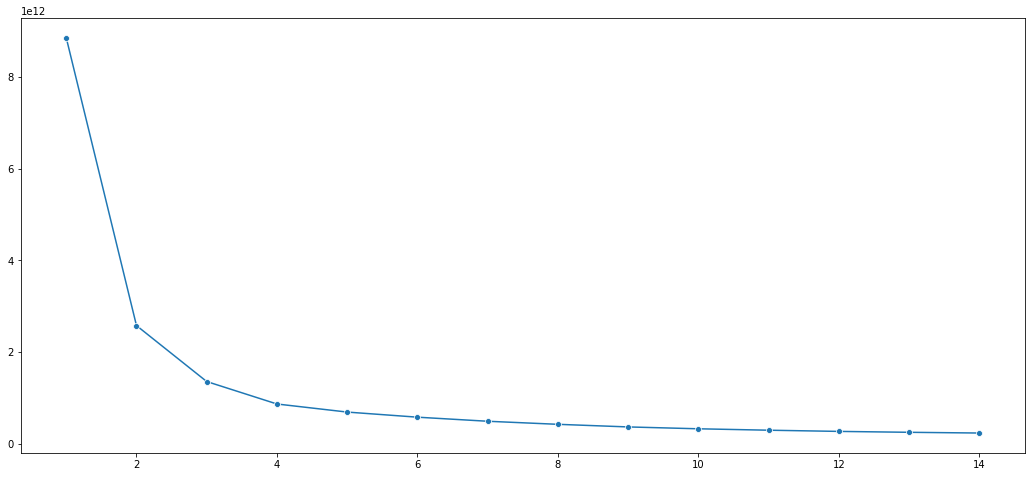

In [189]:
wcss = []
for num in range(1,15):
    kmeans = KMeans(n_clusters=num)
    kmeans.fit(cluster)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize  = (18,8))
sns.lineplot(range(1,15),wcss,marker = 'o')

In [190]:
# from elbow curve we can see n_clusters should be 3
km = KMeans(n_clusters=3)
km.fit(cluster)
cluster['labels']  = km.labels_
cluster.head()

,State,CLV,Response,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,labels
0,4,2763.519279,0,0,0,1,0,56274,1,1,69,32,5,0,1,0,2,0,0,384.811147,5,1,2
1,0,6979.535903,0,1,0,4,0,0,1,2,94,13,42,0,8,1,5,2,0,1131.464935,0,1,1
2,2,12887.431650,0,2,0,1,0,48767,1,1,108,18,38,0,2,1,5,0,0,566.472247,5,1,0
3,1,7645.861827,0,0,0,4,1,0,1,1,106,18,65,0,7,0,1,0,2,529.881344,3,1,1
4,4,2813.692575,0,0,0,1,1,43836,0,2,73,12,44,0,1,1,3,0,0,138.130879,0,1,0


In [191]:
cluster['labels'].value_counts()

0    3482
2    2921
1    2731
Name: labels, dtype: int64

### Classification on Clustered Labels

In [192]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [193]:
cluster.head()

,State,CLV,Response,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,labels
0,4,2763.519279,0,0,0,1,0,56274,1,1,69,32,5,0,1,0,2,0,0,384.811147,5,1,2
1,0,6979.535903,0,1,0,4,0,0,1,2,94,13,42,0,8,1,5,2,0,1131.464935,0,1,1
2,2,12887.431650,0,2,0,1,0,48767,1,1,108,18,38,0,2,1,5,0,0,566.472247,5,1,0
3,1,7645.861827,0,0,0,4,1,0,1,1,106,18,65,0,7,0,1,0,2,529.881344,3,1,1
4,4,2813.692575,0,0,0,1,1,43836,0,2,73,12,44,0,1,1,3,0,0,138.130879,0,1,0


In [194]:
# target variable = labels
y = cluster.iloc[:,-1]
X = cluster.iloc[:,:-1]
print('X shape',X.shape)
print('y shape',y.shape)
print('cluster',cluster.shape)

X shape (9134, 22)
y shape (9134,)
cluster (9134, 23)


In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [196]:
names = []
accuracy = []

def mdl(algos):
    name = str(algos).split('(')[0]
    algos.fit(X_train,y_train)
    y_pred = algos.predict(X_test)
    print(' \n')
    print('-----',name,'------')
    a = accuracy_score(y_test,y_pred)
    print('Accuracy : ',accuracy_score(y_test,y_pred))
    print('Confusion Matrix : \n' , confusion_matrix(y_test,y_pred))
    names.append(name)
    accuracy.append(a)
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
nb = GaussianNB()
adb = AdaBoostClassifier()

li = [lr,dt,rf,nb,adb]

for i in li:
    mdl(i)
    
    

 

----- LogisticRegression ------
Accuracy :  0.9091406677613574
Confusion Matrix : 
 [[563   4  87]
 [ 48 521   0]
 [ 27   0 577]]
 

----- DecisionTreeClassifier ------
Accuracy :  1.0
Confusion Matrix : 
 [[654   0   0]
 [  0 569   0]
 [  0   0 604]]
 

----- RandomForestClassifier ------
Accuracy :  0.9978106185002736
Confusion Matrix : 
 [[654   0   0]
 [  4 565   0]
 [  0   0 604]]
 

----- GaussianNB ------
Accuracy :  0.9458128078817734
Confusion Matrix : 
 [[618   0  36]
 [ 57 512   0]
 [  6   0 598]]
 

----- AdaBoostClassifier ------
Accuracy :  1.0
Confusion Matrix : 
 [[654   0   0]
 [  0 569   0]
 [  0   0 604]]


In [197]:
pd.DataFrame({'Models':names,'Accuracy':accuracy})

,Models,Accuracy
0,LogisticRegression,0.909141
1,DecisionTreeClassifier,1.000000
2,RandomForestClassifier,0.997811
3,GaussianNB,0.945813
4,AdaBoostClassifier,1.000000
